<a href="https://colab.research.google.com/github/vgeneva/EKG/blob/main/EKG_Gateaux_5ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


In [ ]:
#!pip install dtw-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.7/764.7 kB 34.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed();
from matplotlib import pyplot as plt
import pandas as pd
from numpy import linalg as LA
from scipy.integrate import solve_ivp  # solve ODE
from matplotlib.animation import PillowWriter    # writing the .gif
import time
import tensorflow as tf
import random

from scipy.interpolate import interp1d
#from dtw import *

import tensorflow_probability as tfp



# Initial trajectories


In [ ]:
def i_traj(n, a = 0, b = 1):
  h_x = (b-a)/n
  k_x = (round((b-a)/h_x)) #int makes it round down. round, lets it round
  x_ini = tf.linspace(start = a, stop = b, num = n)
  x_ini = tf.reshape(x_ini, (n,1))
  x = tf.reshape(x_ini, (n,1))
  return x

## Select x(0) $\in \mathbb{R}^n$, where $n = 256$.

Since our trajectories have 256 initial trajectories, we choose 256

Define $x(0)$ vector. I will start with 256.

In [ ]:
x0 = i_traj(256)

In [ ]:
print(x0[-1])
print(x0.shape)

tf.Tensor([1.], shape=(1,), dtype=float64)
(256, 1)


# Bring in CSVs

## Data with 256 length signals.
Train Matrices are (256, 10)

Test Matrices are (256, m), where m =1000, 982, 50, 500

In [ ]:
N_train_matrix = tf.convert_to_tensor(pd.read_csv('N_train_matrix.csv'), dtype = tf.float64)
N_test_matrix = tf.convert_to_tensor(pd.read_csv('N_test_matrix.csv'), dtype = tf.float64)

V_train_matrix = tf.convert_to_tensor(pd.read_csv('V_train_matrix.csv'), dtype = tf.float64)
V_test_matrix = tf.convert_to_tensor(pd.read_csv('V_test_matrix.csv'), dtype = tf.float64)

A_train_matrix = tf.convert_to_tensor(pd.read_csv('A_train_matrix.csv'), dtype = tf.float64)
A_test_matrix = tf.convert_to_tensor(pd.read_csv('A_test_matrix.csv'), dtype = tf.float64)

R_train_matrix = tf.convert_to_tensor(pd.read_csv('R_train_matrix.csv'), dtype = tf.float64)
R_test_matrix = tf.convert_to_tensor(pd.read_csv('R_test_matrix.csv'), dtype = tf.float64)

L_train_matrix = tf.convert_to_tensor(pd.read_csv('L_train_matrix.csv'), dtype = tf.float64)
L_test_matrix = tf.convert_to_tensor(pd.read_csv('L_test_matrix.csv'), dtype = tf.float64)

E_train_matrix = tf.convert_to_tensor(pd.read_csv('E_train_matrix.csv'), dtype = tf.float64)
E_test_matrix = tf.convert_to_tensor(pd.read_csv('E_test_matrix.csv'), dtype = tf.float64)

J_train_matrix = tf.convert_to_tensor(pd.read_csv('J_train_matrix.csv'), dtype = tf.float64)
J_test_matrix = tf.convert_to_tensor(pd.read_csv('J_test_matrix.csv'), dtype = tf.float64)

j_train_matrix = tf.convert_to_tensor(pd.read_csv('j_train_matrix.csv'), dtype = tf.float64)
j_test_matrix = tf.convert_to_tensor(pd.read_csv('j_test_matrix.csv'), dtype = tf.float64)

## Some examples

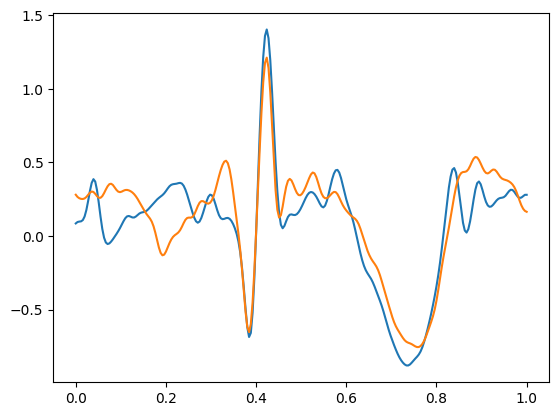

In [ ]:
plt.plot(x0, N_train_matrix[:,0:1])
plt.plot(x0, N_test_matrix[:,0:1]);

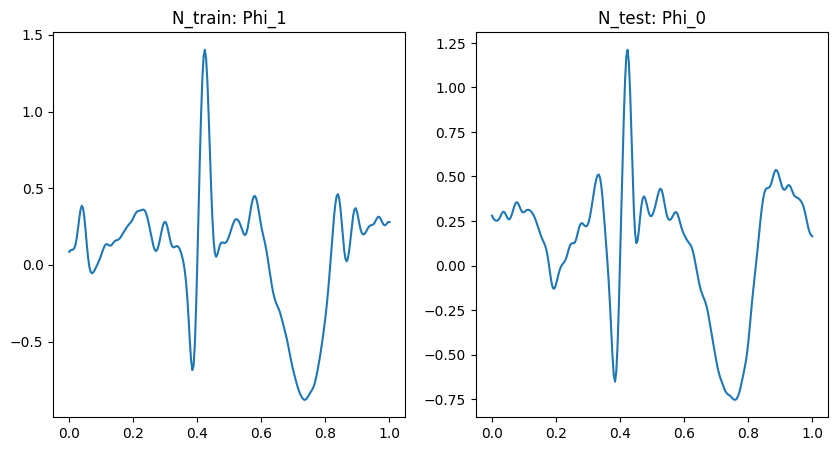

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) # 1 row, 2 columns
ax1.plot(x0, N_train_matrix[:,0:1]);
ax1.set_title('N_train: Phi_1')
ax2.plot(x0, N_test_matrix[:,0:1]);
ax2.set_title('N_test: Phi_0');

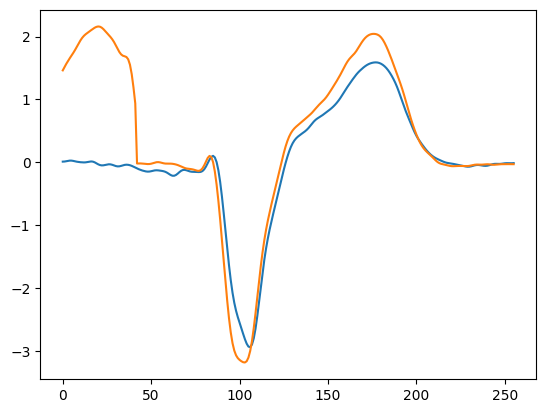

In [ ]:
plt.plot(L_train_matrix[:,0:1]);
plt.plot(L_test_matrix[:,0:1]);

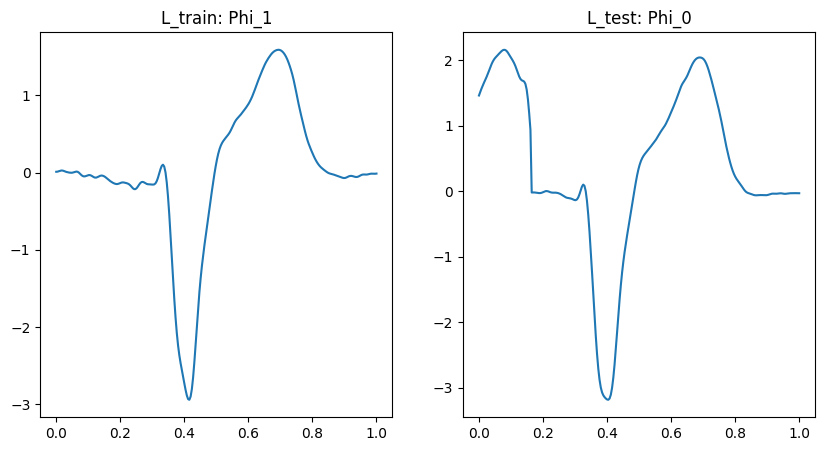

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) # 1 row, 2 columns
ax1.plot(x0, L_train_matrix[:,0:1]);
ax1.set_title('L_train: Phi_1')
ax2.plot(x0, L_test_matrix[:,0:1]);
ax2.set_title('L_test: Phi_0');

# Kernel Functions

In [ ]:
# A collection of vectorized kernel functions
# x, and y are assumed to be Matrices
# if you want to evaluate on a single point
# reshape the vectors from d to d x 1, this
# will turn them into matrices. All the kernel
# functions work with vectors or matrices with the
# exception of k5v which requires matrices as inputs.

# Linear kernel, notice, if x, and y
# are vectors, this will return a scalar
# if x, and y are matrices, this will
# return a matrix and this is an efficient
# and vectorized implementation of the linear
# kernel function.
def k1v(x,y):
    # np.dot computes the vector dot
    # product if x, and y are vectors
    # or it computes the matrix product
    # of x and y, if x or y are matrices
    return (np.dot(x,y.T))

# Affine kernel. Again, if x and y are
# vectors, this will return a scalar but
# if x, and y are matrices this is a vectorized
# version of the affine kernel.
def k2v(x,y):
    return (np.dot(x,y.T)+1)

# Quadratic kernel. Again, if x and y are
# vectors, this will return a scalar but
# if x, and y are matrices this is a vectorized
# version of the Quadratic kernel.
def k3v(x,y):
    # To raise a number by a power python
    # uses ** instead of ^, ^ is reserved
    # for bit operations. (and?)
    return ((1+np.dot(x,y.T))**2)

# dth order kernel, (here d=4)
d = 4
def k4v(x,y):
    return ((1+np.dot(x,y.T))**d)

# Gaussian kernel. This is the only kernel function
# in this set of example kernels that is tricky to
# efficiently vectorize. This is because to evaluate
# this kernel function, we have to evaluate (x-y)^T(x-y)
# whereas in all the other examples, we evaluate x^Ty
# Expanding (x-y)^T(x-y) gives us x^Tx - 2x^Ty + y^Ty
# So k(x_i,y_j) = e^(-(x_i-y_j)^T(x_i-y_j)/(2*sigma^2))
# So k(x_i,x_j) = f(x_i^Tx_i+y_j^Ty_j-2x_i^Ty_j)
# we get x_i^Ty_j using np.dot(X,Y) where X and Y are the
# X and Y data matrices respectively. We get x_i^Tx_i using
# np.sum(X*X,axis=1).reshape(d,1). This function requires
# matrices and will fail if x, or y are vectors. It is
# vectorized and efficient. For any kernel function that uses
# k(x_i,x_j) = f((x_i-x_j)^T(x_i-x_j)) use the line that
# computes XminusYSquared to compute the matrix whose i,jth
# entry is (x_i-x_j)^T(x_i-x_j) in a vectorized and efficient
# manner. Then apply f(XminusYsquared).

# sigma can be picked for the specific problem at hand
sigma = 2**0;
def k5v(x,y):
    numxPoints = np.shape(x)[0];
    numyPoints = np.shape(y)[0];
    XminusYSquared =np.sum(x*x,axis=1).reshape([numxPoints,1])-2*np.dot(x,y.T)+np.sum(y*y,axis=1).reshape([1,numyPoints]);
    return np.exp(-XminusYSquared/(2*sigma**2))


def gauss_0(x,y): # zero boundary conditions
    numxPoints = np.shape(x)[0];
    numyPoints = np.shape(y)[0];
    XminusYSquared =np.sum(x*x,axis=1).reshape([numxPoints,1])-2*np.dot(x,y.T)+np.sum(y*y,axis=1).reshape([1,numyPoints]);
    return np.exp(-XminusYSquared/(2*sigma**2))



def k7v(x,y):
    return np.exp(-1/(2*sigma**2) * (x-y)**2)




# Variables for Random Fouirer Features

\begin{align}
    \gamma(x) = \frac{1}{\sqrt{2p}} \begin{bmatrix}
        \cos(z_1x) \\
        \vdots\\
        \cos(z_{p/2}x)\\
        \sin(z_1x)\\
        \vdots\\
        \sin(z_{p/2}x)
    \end{bmatrix}
\end{align}

In [ ]:
num_features = 50

In [ ]:
feature_coeff = 1 / np.sqrt(num_features)

## Z's for guassian random Fourier features for $\gamma$


In [ ]:
np.random.seed(3) # set the seed for reproducibility
# creating fourier samples (create a vector of random numbers to be the scalar inputs, which are x)
# in the feature_map, we have cosines and sines and we have num_features cosines and
# num_features sines for the fourier features. Our input is num_features, but our vector col will be
# 2 * num_features.

# we need to make our standard deviation 1/sqrt(\sigma^2). Here , when I selet
# fourier, sample, its with sigma = 1, so this is 1\sqrt (1).

#these are the randomly picked z's for the fourier-features
fourier_sample_gamma = np.random.normal(scale = 1, size = (num_features,1))
fourier_sample_gamma = tf.constant(fourier_sample_gamma, dtype = tf.float64) #make into a tensor

print(fourier_sample_gamma.shape)

(50, 1)


## $\beta$ for $\gamma$

$\beta^T \gamma(x)$

In [ ]:
np.random.seed(3) # set the seed for reproducitilbity
 # 2 * num_features
beta_t = np.random.normal(scale = 2 / np.sqrt(num_features), size = ((2 * num_features), 1))

beta_t = tf.constant(beta_t)
print(beta_t.shape)
#print(beta)

(100, 1)


## $\beta$ for projected $\gamma$
Size ((2*num_features)-2,1)

In [ ]:
np.random.seed(5) # set the seed for reproducitilbity
 # 2 * num_features - 2 (for dimensions)
beta_true = np.random.normal(scale = 1 / np.sqrt(num_features), size = ((2 * num_features) - 2, 1)) / 4

beta_true = tf.constant(beta_true, dtype = tf.float64)
print(beta_true.shape)
#print(beta)

(98, 1)


# Random Fourier Features

## Function for $\gamma(x)$.

First we leverage Michael's code to create a fourier features map we denote as $\gamma(x)$. Our inputs for this function are: an $x$ value, fourier_sample (which are scaling the inputs into the $\sin$ and $\cos$ components of the vector), and a feature coefficient which in our case is $1 / \sqrt{\text{number of features}}$. \begin{align}
    \gamma(x) = \frac{1}{\sqrt{2p}} \begin{bmatrix}
        \cos(z_1x) \\
        \vdots\\
        \cos(z_{p/2}x)\\
        \sin(z_1x)\\
        \vdots\\
        \sin(z_{p/2}x)
    \end{bmatrix}
\end{align}

In [ ]:
#feature map: Computes a feature map for a Gaussian kernel Fourier features approximation.
#Input:
#x - (n,d) matrix of n d-vectors to perform feature map on
#fourier_sample - (d,p) matrix of p samples from a d-dimensional standard normal distribution
#feature_coeff - 1/sqrt(p).  This could be computed from fourier_sample.
#Output:
#M - (2p+1,n) matrix of n feature vectors
#The +1 comes from the fact that this feature vector incorporates a constant term
# in regards to bandwidth, we are sampling from a normal distribution but using the guassian kernel.
# so we need to make our standard deviation 1/sqrt(\sigma^2). Here , when i selet
# fourier, sample, its with sigma = 1, so this is 1\sqrt (1).
def feature_map(x,fourier_sample,feature_coeff,bandwidth = .1):  #original 0.1#bandwith is the sigma

    x = tf.transpose(x) #make x (n,d) into a row tensor (if d=1)
    # fourierx: fourier_sample is an outer product which creates a
    # matrix which its rows are scaled x row vectors by each fourier_sample
    # (p, n)
    fourierx = tf.linalg.matmul(fourier_sample,x)
    #print(f' fourier x: {fourierx.shape}')
    # then take cosine, stiill be (p,n)
    cos_fourierx = feature_coeff*tf.cos(fourierx/bandwidth)
    #print(f' cos_fourierx: {cos_fourierx.shape}')
    sin_fourierx = feature_coeff*tf.sin(fourierx/bandwidth)
    #print(f' sin_fourierx: {sin_fourierx.shape}')
    M = tf.concat([cos_fourierx,sin_fourierx],axis=0)
    #print(f' M: {M.shape}')
    return M

In [ ]:
feature_map(x0, fourier_sample_gamma, feature_coeff)

<tf.Tensor: shape=(100, 256), dtype=float64, numpy=
array([[ 0.14142136,  0.14107361,  0.14003207, ...,  0.06369962,
         0.0723921 ,  0.08072857],
       [ 0.14142136,  0.14140064,  0.14133848, ..., -0.0526565 ,
        -0.05040211, -0.04813294],
       [ 0.14142136,  0.14142034,  0.14141731, ...,  0.08140819,
         0.08097   ,  0.08053065],
       ...,
       [ 0.        ,  0.00016479,  0.00032958, ...,  0.0410908 ,
         0.04124845,  0.04140605],
       [ 0.        , -0.01245254, -0.02480835, ...,  0.04382746,
         0.05549669,  0.06673481],
       [ 0.        , -0.00148496, -0.00296976, ..., -0.06592868,
        -0.06461132, -0.06328684]])>

In [ ]:
fourier_sample_gamma.shape

TensorShape([50, 1])

### test
$\alpha(x) = \beta^T \gamma(x)$

In [ ]:
x0.shape

TensorShape([256, 1])

In [ ]:
fourier_sample_gamma.shape
x0_m = tf.broadcast_to(x0, [len(x0), 2])
print(x0_m.shape)

(256, 2)


In [ ]:
def alpha_test(t, x, b = beta_t, fourier_sample = fourier_sample_gamma, feature_coeff = feature_coeff):
  return tf.linalg.matmul(tf.transpose(b), feature_map(x,fourier_sample, feature_coeff))

In [ ]:
print(len(N_test_matrix[0])*len(x0))
x0_long_vector = tf.tile(x0, (len(N_test_matrix[0]),1))
print(x0_long_vector.shape)
#print(x0_long_vector[250:260,:])
a_long = alpha_test(1, x0_long_vector, beta_t)
#print(tf.transpose(a_long)[0:10,:])
#print(tf.transpose(a_long)[250:260,:])
print(tf.transpose(a_long).shape)
print(tf.transpose(a_long)[0:5,:])
print(tf.transpose(a_long)[256:256+5,:])

256000
(256000, 1)
(256000, 1)
tf.Tensor(
[[-0.58785364]
 [-0.58645566]
 [-0.58306229]
 [-0.57767802]
 [-0.57032077]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-0.58785364]
 [-0.58645566]
 [-0.58306229]
 [-0.57767802]
 [-0.57032077]], shape=(5, 1), dtype=float64)


In [ ]:
x_arr = tf.constant([[1,2,3,4,5,6,7,8,9,10]])
print(x_arr)
x_arr_1 = tf.reshape(x_arr, (2,5))
print(tf.transpose(x_arr_1))

tf.Tensor([[ 1  2  3  4  5  6  7  8  9 10]], shape=(1, 10), dtype=int32)
tf.Tensor(
[[ 1  6]
 [ 2  7]
 [ 3  8]
 [ 4  9]
 [ 5 10]], shape=(5, 2), dtype=int32)


In [ ]:
a_long_reshape = tf.reshape(a_long, (1000,256))
print(tf.transpose(a_long_reshape))
print(tf.transpose(a_long_reshape)[:,0:5])

tf.Tensor(
[[-0.58785364 -0.58785364 -0.58785364 ... -0.58785364 -0.58785364
  -0.58785364]
 [-0.58645566 -0.58645566 -0.58645566 ... -0.58645566 -0.58645566
  -0.58645566]
 [-0.58306229 -0.58306229 -0.58306229 ... -0.58306229 -0.58306229
  -0.58306229]
 ...
 [-0.09400652 -0.09400652 -0.09400652 ... -0.09400652 -0.09400652
  -0.09400652]
 [-0.12321699 -0.12321699 -0.12321699 ... -0.12321699 -0.12321699
  -0.12321699]
 [-0.15288538 -0.15288538 -0.15288538 ... -0.15288538 -0.15288538
  -0.15288538]], shape=(256, 1000), dtype=float64)
tf.Tensor(
[[-0.58785364 -0.58785364 -0.58785364 -0.58785364 -0.58785364]
 [-0.58645566 -0.58645566 -0.58645566 -0.58645566 -0.58645566]
 [-0.58306229 -0.58306229 -0.58306229 -0.58306229 -0.58306229]
 ...
 [-0.09400652 -0.09400652 -0.09400652 -0.09400652 -0.09400652]
 [-0.12321699 -0.12321699 -0.12321699 -0.12321699 -0.12321699]
 [-0.15288538 -0.15288538 -0.15288538 -0.15288538 -0.15288538]], shape=(256, 5), dtype=float64)


In [ ]:
b_long = tf.tile(beta_t, (1, len(N_test_matrix[0])))
print(b_long.shape)
print(b_long[0:5,:])
print(b_long[98:101,:])

(100, 1000)
tf.Tensor(
[[ 0.50590053  0.50590053  0.50590053 ...  0.50590053  0.50590053
   0.50590053]
 [ 0.12346363  0.12346363  0.12346363 ...  0.12346363  0.12346363
   0.12346363]
 [ 0.02729361  0.02729361  0.02729361 ...  0.02729361  0.02729361
   0.02729361]
 [-0.52707533 -0.52707533 -0.52707533 ... -0.52707533 -0.52707533
  -0.52707533]
 [-0.07845723 -0.07845723 -0.07845723 ... -0.07845723 -0.07845723
  -0.07845723]], shape=(5, 1000), dtype=float64)
tf.Tensor(
[[-0.0849111  -0.0849111  -0.0849111  ... -0.0849111  -0.0849111
  -0.0849111 ]
 [ 0.61041681  0.61041681  0.61041681 ...  0.61041681  0.61041681
   0.61041681]], shape=(2, 1000), dtype=float64)


In [ ]:
alpha_x_b = alpha_test(1, x0_long_vector, b_long)
print(alpha_x_b.shape)
print(alpha_x_b[0:5,:])
print(alpha_x_b[98:101,:])

(1000, 256000)
tf.Tensor(
[[-0.58785364 -0.58645566 -0.58306229 ... -0.09400652 -0.12321699
  -0.15288538]
 [-0.58785364 -0.58645566 -0.58306229 ... -0.09400652 -0.12321699
  -0.15288538]
 [-0.58785364 -0.58645566 -0.58306229 ... -0.09400652 -0.12321699
  -0.15288538]
 [-0.58785364 -0.58645566 -0.58306229 ... -0.09400652 -0.12321699
  -0.15288538]
 [-0.58785364 -0.58645566 -0.58306229 ... -0.09400652 -0.12321699
  -0.15288538]], shape=(5, 256000), dtype=float64)
tf.Tensor(
[[-0.58785364 -0.58645566 -0.58306229 ... -0.09400652 -0.12321699
  -0.15288538]
 [-0.58785364 -0.58645566 -0.58306229 ... -0.09400652 -0.12321699
  -0.15288538]
 [-0.58785364 -0.58645566 -0.58306229 ... -0.09400652 -0.12321699
  -0.15288538]], shape=(3, 256000), dtype=float64)


In [ ]:
alpha_fixed_x0 = alpha_test(1, x0)

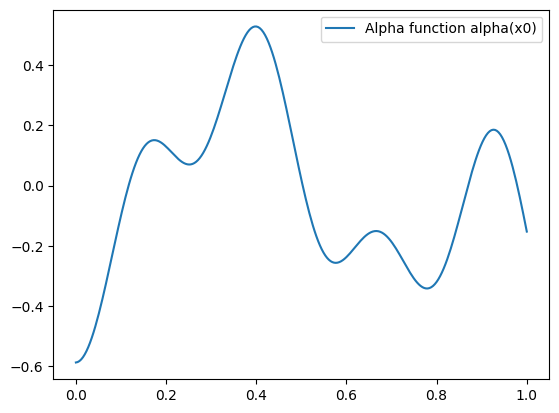

In [ ]:

plt.plot(x0, tf.transpose(alpha_fixed_x0), label = 'Alpha function alpha(x0)');
plt.legend();

In [ ]:
feature_map(x0,fourier_sample_gamma,feature_coeff)

<tf.Tensor: shape=(100, 256), dtype=float64, numpy=
array([[ 0.14142136,  0.14107361,  0.14003207, ...,  0.06369962,
         0.0723921 ,  0.08072857],
       [ 0.14142136,  0.14140064,  0.14133848, ..., -0.0526565 ,
        -0.05040211, -0.04813294],
       [ 0.14142136,  0.14142034,  0.14141731, ...,  0.08140819,
         0.08097   ,  0.08053065],
       ...,
       [ 0.        ,  0.00016479,  0.00032958, ...,  0.0410908 ,
         0.04124845,  0.04140605],
       [ 0.        , -0.01245254, -0.02480835, ...,  0.04382746,
         0.05549669,  0.06673481],
       [ 0.        , -0.00148496, -0.00296976, ..., -0.06592868,
        -0.06461132, -0.06328684]])>

In [ ]:
feature_map(x0_long_vector, fourier_sample_gamma, feature_coeff)

<tf.Tensor: shape=(100, 256000), dtype=float64, numpy=
array([[ 0.14142136,  0.14107361,  0.14003207, ...,  0.06369962,
         0.0723921 ,  0.08072857],
       [ 0.14142136,  0.14140064,  0.14133848, ..., -0.0526565 ,
        -0.05040211, -0.04813294],
       [ 0.14142136,  0.14142034,  0.14141731, ...,  0.08140819,
         0.08097   ,  0.08053065],
       ...,
       [ 0.        ,  0.00016479,  0.00032958, ...,  0.0410908 ,
         0.04124845,  0.04140605],
       [ 0.        , -0.01245254, -0.02480835, ...,  0.04382746,
         0.05549669,  0.06673481],
       [ 0.        , -0.00148496, -0.00296976, ..., -0.06592868,
        -0.06461132, -0.06328684]])>

In [ ]:
print(x0.shape)
print(beta_t.shape)
print(beta_t[0:5])
print(len(beta_t))
print(len(N_test_matrix[0]))
x0_m = tf.broadcast_to(x0, [len(x0), 2])
print(x0_m.shape)
print(x0_m[0:6, 0:2])
a_x0 = alpha_test(1, x0, beta_t)
print(a_x0.shape)
print(a_x0[0:6, 0:2])

(256, 1)
(100, 1)
tf.Tensor(
[[ 0.50590053]
 [ 0.12346363]
 [ 0.02729361]
 [-0.52707533]
 [-0.07845723]], shape=(5, 1), dtype=float64)
100
1000
(256, 2)
tf.Tensor(
[[0.         0.        ]
 [0.00392157 0.00392157]
 [0.00784314 0.00784314]
 [0.01176471 0.01176471]
 [0.01568627 0.01568627]
 [0.01960784 0.01960784]], shape=(6, 2), dtype=float64)
(1, 256)
tf.Tensor([[-0.58785364 -0.58645566]], shape=(1, 2), dtype=float64)


In [ ]:
beta_m = tf.broadcast_to(beta_t, [len(beta_t), len(N_test_matrix[0])])
print(beta_m.shape)
print(beta_m[0:5, 0:5])
#alpha_test(1, x0) \in (256,1)
# because alpha is evaluated at each x0 (256).
# now, i am compute x0 with 1000 betas
alpha_beta_m = alpha_test(1, x0, beta_m)
print(alpha_beta_m.shape)
print(alpha_beta_m[0:5, 0:5])

(100, 1000)
tf.Tensor(
[[ 0.50590053  0.50590053  0.50590053  0.50590053  0.50590053]
 [ 0.12346363  0.12346363  0.12346363  0.12346363  0.12346363]
 [ 0.02729361  0.02729361  0.02729361  0.02729361  0.02729361]
 [-0.52707533 -0.52707533 -0.52707533 -0.52707533 -0.52707533]
 [-0.07845723 -0.07845723 -0.07845723 -0.07845723 -0.07845723]], shape=(5, 5), dtype=float64)
(1000, 256)
tf.Tensor(
[[-0.58785364 -0.58645566 -0.58306229 -0.57767802 -0.57032077]
 [-0.58785364 -0.58645566 -0.58306229 -0.57767802 -0.57032077]
 [-0.58785364 -0.58645566 -0.58306229 -0.57767802 -0.57032077]
 [-0.58785364 -0.58645566 -0.58306229 -0.57767802 -0.57032077]
 [-0.58785364 -0.58645566 -0.58306229 -0.57767802 -0.57032077]], shape=(5, 5), dtype=float64)


In [ ]:
#alpha_xb_long = alpha_test(1, x0_long_vector, beta_m)
#print(alpha_xb_long.shape)
#print(alpha_xb_long[0:5, 0:5])

In [ ]:
print(len(x0_m[0]))
print(x0_m.shape)

2
(256, 2)


In [ ]:
new_x0 = i_traj(256, 1, 2)
shift_x0 = tf.roll(x0, shift = 1, axis = 0)
print(shift_x0[0:5,:])
x0_m2 = tf.concat([x0, new_x0], axis = 1)
x0_m3 = tf.concat([x0, shift_x0], axis =1)
print(x0_m2.shape)
print(x0_m2[0:5, :])

tf.Tensor(
[[1.        ]
 [0.        ]
 [0.00392157]
 [0.00784314]
 [0.01176471]], shape=(5, 1), dtype=float64)
(256, 2)
tf.Tensor(
[[0.         1.        ]
 [0.00392157 1.00392157]
 [0.00784314 1.00784314]
 [0.01176471 1.01176471]
 [0.01568627 1.01568627]], shape=(5, 2), dtype=float64)


In [ ]:
a_m = []
for i in range(len(x0_m[0])):
  a_m.append(alpha_test(1, x0_m[:,i:i+1], beta_t))

a_t = tf.keras.layers.Concatenate(axis=0)(a_m)
tf.transpose(a_t)[0:5,:]
print(a_t.shape)

(2, 256)


In [ ]:
a_m2 = []
for i in range(len(x0_m2[0])):
  a_m2.append(alpha_test(1, x0_m2[:,i:i+1], beta_t))

a_t2 = tf.keras.layers.Concatenate(axis=0)(a_m2)
tf.transpose(a_t2)[0:5,:]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-0.5878536 , -0.15288538],
       [-0.58645564, -0.18282105],
       [-0.5830623 , -0.21283074],
       [-0.577678  , -0.24272   ],
       [-0.5703208 , -0.27229455]], dtype=float32)>

In [ ]:
beta_2 = tf.broadcast_to(beta_t, [len(beta_t), 2])
print(beta_2.shape)
print(beta_2[0:5, :])
print(beta_t.shape)

(100, 2)
tf.Tensor(
[[ 0.50590053  0.50590053]
 [ 0.12346363  0.12346363]
 [ 0.02729361  0.02729361]
 [-0.52707533 -0.52707533]
 [-0.07845723 -0.07845723]], shape=(5, 2), dtype=float64)
(100, 1)


In [ ]:
a_m3 = []
for i in range(len(x0_m2[0])):
  a_m3.append(alpha_test(1, x0_m2[:,i:i+1], beta_2[:,i:i+1]))

a_t3 = tf.keras.layers.Concatenate(axis=0)(a_m3)
tf.transpose(a_t3)[0:5,:]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-0.5878536 , -0.15288538],
       [-0.58645564, -0.18282105],
       [-0.5830623 , -0.21283074],
       [-0.577678  , -0.24272   ],
       [-0.5703208 , -0.27229455]], dtype=float32)>

In [ ]:
def alpha_test_m(t, x, b, fourier_sample, feature_coeff):
  d = len(x[0])
  print(d)
  a_list = []
  for i in range(d):
    a_list.append(alpha_test(t, x[:,i:i+1], b[:,i:i+1], fourier_sample, feature_coeff))
  m = tf.keras.layers.Concatenate(axis=0)(a_list)
  return m


In [ ]:
alpha_matrix = alpha_test_m(1, x0_m2, beta_2, fourier_sample_gamma, feature_coeff)
print(alpha_matrix.shape)
print(alpha_matrix[:,0:5])

2
(2, 256)
tf.Tensor(
[[-0.5878536  -0.58645564 -0.5830623  -0.577678   -0.5703208 ]
 [-0.15288538 -0.18282105 -0.21283074 -0.24272    -0.27229455]], shape=(2, 5), dtype=float32)


## k9v, Kernel function for Guassian Random Fourier Features, $k(x,y) = \gamma(x)^T\gamma(y)$

In [ ]:
# normal guassian
def k9v(x,y,
        fourier_sample = fourier_sample_gamma,
        feature_coeff = feature_coeff,
        feature_map = feature_map):

    return tf.linalg.matmul(tf.transpose(feature_map(x, fourier_sample, feature_coeff))
                                                       , feature_map(y, fourier_sample
                                                       , feature_coeff))

## k8v, Now create projection kernel function for $\gamma_0(x) = \Lambda^{1/2} U^T \gamma(x)$, $k_0(x,y) = \gamma_0(x)^T \gamma_0(y)$.

This is the explicit kernel function, but with ensuring we start and end at the same place for phi_0 and phi_1.

Using $k_0(x,y) = \gamma(x)^T A \gamma(y)$, where $A$ is a Hermitian matrix described below and in the notes of Dr. Bruno.

When we generate our $\alpha$ function, we ensured that the $\alpha(0) = \alpha(1) = 0$.  We did this by following Dr. Bruno's notes on A RKHS constrained to functions verifying $\alpha(0) = 0$ and $\alpha(1) = 0$. We first start by considering an explicit kernel with random fourier features: $k(x,y)  = \gamma(x)^T \gamma(y)$, k9v above

First make tensor flow arrays for $x_1 = [1], x_0 =[0], x_{01} =[0 ,1 ]$.

In [ ]:
x_01 = np.array([0.,1.])
# reshape x_1 into a column vector
x_01 = np.reshape(x_01, (len(x_01),1))
# make numpy array into a tensorflow array
x_01 = tf.constant(x_01)

In [ ]:
x_0 = np.array([0.])
x_0 = np.reshape(x_0, (len(x_0),1))
# make numpy array into a tensorflow array
x_0 = tf.constant(x_0)

In [ ]:
x_1 = np.array([1.])
x_1 = np.reshape(x_1, (len(x_1),1))
# make numpy array into a tensorflow array
x_1 = tf.constant(x_1)

Now, let's create a gram matrix with our end points, $x = [0,1]$. Here we make  
G =\begin{bmatrix} k(0,0) & k(0,1) \\
                      k(0,1) & k(1,1)
      \end{bmatrix}

In [ ]:
G = k9v(x_01,x_01)
print(G)
G_inv = tf.linalg.inv(G)
print(G_inv)

tf.Tensor(
[[1.         0.03674279]
 [0.03674279 1.        ]], shape=(2, 2), dtype=float64)
tf.Tensor(
[[ 1.00135186 -0.03679246]
 [-0.03679246  1.00135186]], shape=(2, 2), dtype=float64)


$(\gamma(0),\gamma(1))$, with $\gamma(0), \gamma(1) \in \mathbb{R}^p$.

In [ ]:
g0g1 = feature_map(x_01, fourier_sample = fourier_sample_gamma, feature_coeff = feature_coeff)
print(g0g1.shape)

(100, 2)


$(\gamma(0), \gamma(1)) G^{-1} (\gamma(0), \gamma(1))^T$

In [ ]:
gGg = tf.linalg.matmul(tf.linalg.matmul(g0g1, G_inv), tf.transpose(g0g1))
print(gGg.dtype)
print(gGg.shape)

<dtype: 'float64'>
(100, 100)


In [ ]:
I = tf.eye(2 * num_features, dtype=tf.float64)

$A = I - (\gamma(0), \gamma(1)) G^{-1} (\gamma(0), \gamma(1))^T$

In [ ]:
A_g = tf.subtract(I,gGg)
print(A_g.shape)
#print(A_g)

(100, 100)


In [ ]:
# A Hermitian matrix is a square matrix that is equal to its own complex conjugate transpose.
if np.allclose(A_g, np.conj(A_g).T):
    print("A is Hermitian")
else:
    print("A is not Hermitian")

A is Hermitian


In [ ]:
# Use eigh
eig, U = LA.eigh(A_g)

In [ ]:
# Define the condition for removing small values from
# eigenvalues. These are basically zero
condition = eig < 1e-14

# Use boolean indexing to select the elements that satisfy the condition
# this is telling me what meets the condition
remove = tf.boolean_mask(eig, condition)
# Obtain indexes where this condition is met
ind_to_remove = np.where(condition)

# new eig vector with no zeros
new_eig = np.delete(eig, ind_to_remove)
#new_eig = np.where(condition, eig, 0)

# new U matrix removing the eigenvectors corresponding to
# eigenvalues that were removed
new_U = np.delete(U, ind_to_remove, axis=1)


print(remove)
print(ind_to_remove)
print(new_eig)
print(new_eig.shape)
print(new_U.shape)
print(new_U[:,0].shape)

tf.Tensor([-3.60005688e-16  6.93072596e-16], shape=(2,), dtype=float64)
(array([0, 1]),)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
(98,)
(100, 98)
(100,)


In [ ]:
new_L = tf.linalg.diag(tf.sqrt(new_eig))
print(new_L.shape)

(98, 98)


## $Λ^{1/2}U^T = $ LU

will be the same, so I don't need to recalculate every time we go through the equation.

In [ ]:
LU = tf.linalg.matmul(new_L, tf.transpose(new_U))
print(LU.shape)

(98, 100)


In [ ]:
np.linalg.cond(LU)

1.0000000000000029

$\gamma_0(x) = Λ^{1/2}U^T \psi(x)$

In [ ]:
# new feature map to make alpha and learning alpha
def feature_map_0(x, Lambda_unitary = LU, fourier_sample = fourier_sample_gamma,
                  feature_coeff = feature_coeff, bandwidth = .1):#, feature_map = feature_map,
  #print(x.shape)
  p = feature_map(x, fourier_sample, feature_coeff, bandwidth)
  return tf.linalg.matmul(Lambda_unitary, p)

(98, 1)
(98, 1)


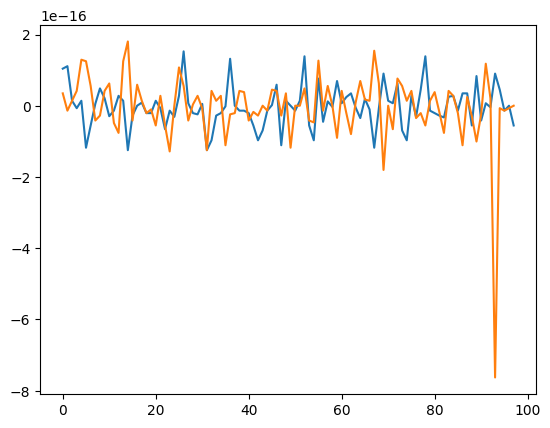

In [ ]:
# An input of 1 dimensional vector should be (p-2,1)
# this graphs should show that gamma_0(0) ≈ 0, gamma_0(1) ≈ 0
f_0 = feature_map_0(x_0)
print(f_0.shape) #length of fourier_features - 2 dimentison, x's with all cos's sine's
f_1 = feature_map_0(x_1)
print(f_1.shape)
plt.plot(f_0);
plt.plot(f_1);#

## New kernel function for $\gamma_0(x) = \Lambda^{1/2} U^T \gamma(x)$ such that $k_0(x,y) = \gamma_0(x)^T \gamma_0(y)$.

This is the explicit kernel function, but with ensuring we start and end at the same place as phi_0 and phi_1.

In [ ]:
# Remeber, LU will be fixed the entire time, will not change since it is about
# gamma(x) at the boundaries only.
def k8v(x,y, Lambda_unitary = LU, fourier_sample = fourier_sample_gamma,
                  feature_coeff = feature_coeff):#, feature_map = feature_map):

    return tf.linalg.matmul(tf.transpose(feature_map_0(x, Lambda_unitary
                                                       , fourier_sample
                                                       , feature_coeff ))#, feature_map))
                                                       , feature_map_0(y, Lambda_unitary
                                                                       , fourier_sample
                                                                       , feature_coeff ))#, feature_map))

In [ ]:
k8v(x0,x0).shape

TensorShape([256, 256])

In [ ]:
x_05 = np.array([0.5])
# reshape x_1 into a column vector
x_05 = np.reshape(x_05, (len(x_05),1))
#print(x_01.shape)
# make numpy array into a tensorflow array
x_05 = tf.constant(x_05)

In [ ]:
x_04 = np.array([0.4])
x_04 = np.reshape(x_04, (len(x_04),1))
# make numpy array into a tensorflow array
x_04 = tf.constant(x_04)

(256, 1)


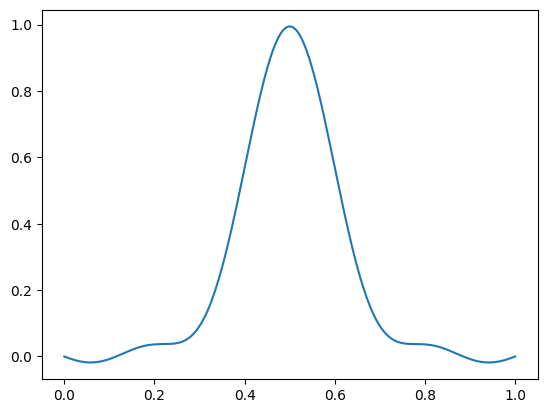

In [ ]:
k8v(x0, x_05)
plt.plot(x0,k8v(x0, x_05));
print(k8v(x0, x_0).shape)

In [ ]:
kv8_gaus_test = k8v(x0,x0)
#plt.plot(x_input,kern_gaus_test[15,:]);
#plt.plot(x_input,kern_gaus_test[16,:]);
#plt.plot(x_input,kern_gaus_test[40,:]);
print(kv8_gaus_test.shape)
np.linalg.cond(kv8_gaus_test)

(256, 256)


3.985069269020007e+32

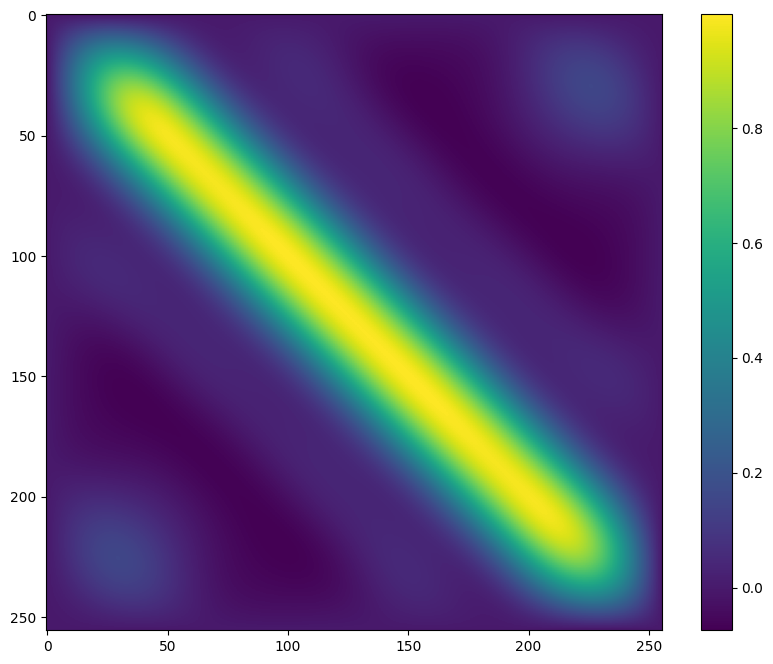

In [ ]:
plt.figure(figsize = (10,8))
plt.imshow(kv8_gaus_test);
plt.colorbar();

In [ ]:
kv9_gaus_test = k9v(x0,x0)
#plt.plot(x_input,kern_gaus_test[15,:]);
#plt.plot(x_input,kern_gaus_test[16,:]);
#plt.plot(x_input,kern_gaus_test[40,:]);
print(kv9_gaus_test.shape)
np.linalg.cond(kv9_gaus_test)

(256, 256)


2.8912653991093745e+18

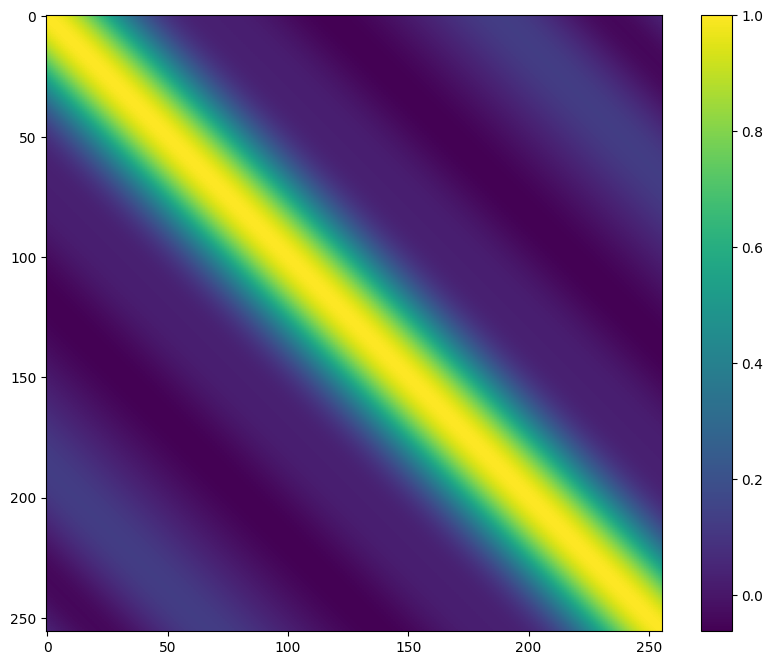

In [ ]:
plt.figure(figsize = (10,8))
plt.imshow(kv9_gaus_test);
plt.colorbar();

## Derivative of $\gamma_0(x)$.

$\frac{d}{dx} \gamma_0(x) = \lambda^{1/2}U^T \frac{d}{dx} \gamma(x)$

where
 \begin{align}
    \gamma(x) = \frac{1}{\sqrt{2p}} \begin{bmatrix}
        \cos(z_1x) \\
        \vdots\\
        \cos(z_{p/2}x)\\
        \sin(z_1x)\\
        \vdots\\
        \sin(z_{p/2}x)
    \end{bmatrix}
\end{align}

So:


\begin{align}
\frac{d}{dx} \gamma(x) = \frac{1}{\sqrt{2p}} \begin{bmatrix}-z_1 \sin(z_1x) \\ \vdots \\ -z_{p/2} \sin(z_{p/2}x)\\  z_1 \cos(z_1x) \\ \vdots \\ z_{p/2} \cos(z_{p/2}x)\end{bmatrix}
\end{align}


In [ ]:
#feature map der: Computes a feature map derivative for a Gaussian kernel Fourier features approximation.
#Input:
#x - (n,d) matrix of n d-vectors to perform feature map on
#fourier_sample - (d,p) matrix of p samples from a d-dimensional standard normal distribution
#feature_coeff - 1/sqrt(p).  This could be computed from fourier_sample.
#Output:
#M - (2p+1,n) matrix of n feature vectors
#The +1 comes from the fact that this feature vector incorporates a constant term
# in regards to bandwidth, we are sampling from a normal distribution but using the guassian kernel.
# so we need to make our standard deviation 1/sqrt(\sigma^2). Here , when i select
# fourier, sample, its with sigma = 1, so this is 1\sqrt (1).
def feature_map_der(x,fourier_sample,feature_coeff,bandwidth = .1):  #oritingal 0.1#bandwith is the sigma

    x = tf.transpose(x) #make x into a tensor for this calc
    #print(f' x shape: {x.shape}')
    fourierx = tf.linalg.matmul(fourier_sample,x)
    #print(f' fourierx shape: {fourierx.shape}')
    #print(f' fourierx: {fourierx[0:5, 0:5]}')
    sin_fourierx = feature_coeff * tf.sin(fourierx/bandwidth)
    #print(f' sin_Fourierx shape: {sin_fourierx.shape}')
    #print(f' sin_fourerier {sin_fourierx[0:5, 0:5]}')
    cos_fourierx = feature_coeff * tf.cos(fourierx/bandwidth)
    #print(f' fourier_sample shape: {fourier_sample.shape}')
    #print(f' fourier_sample: {fourier_sample[0:5, 0:5]}')
    #print(f' cos_fourierx shape: {cos_fourierx.shape}')
    #M = tf.concat([cos_fourierx,sin_fourierx],axis=0
    #print(cos_fourierx.shape)
    #a = - tf.linalg.matmul(fourier_sample,sin_fourierx)
    a = (-fourier_sample/bandwidth) * sin_fourierx #hadamard product
    #print(f'a shape: {a.shape}')
    #print(f' a: {a[0:5, 0:5]}')
    #b =  tf.linalg.matmul(fourier_sample,cos_fourierx)
    b =  (fourier_sample/bandwidth) * cos_fourierx
    #print(f' b shape: {b.shape}')
    M = tf.concat([a,b],axis=0)

    return M

In [ ]:
feature_map_der(x0, fourier_sample_gamma, feature_coeff)

<tf.Tensor: shape=(100, 256), dtype=float64, numpy=
array([[-0.00000000e+00, -1.77279665e-01, -3.53687482e-01, ...,
         2.25837691e+00,  2.17297257e+00,  2.07688172e+00],
       [-0.00000000e+00, -1.05667566e-02, -2.11304170e-02, ...,
         5.72931326e-01,  5.76781788e-01,  5.80463241e-01],
       [-0.00000000e+00, -5.16423049e-04, -1.03283870e-03, ...,
        -1.11590077e-01, -1.11886553e-01, -1.12181427e-01],
       ...,
       [ 4.20216807e-02,  4.20216521e-02,  4.20215666e-02, ...,
         4.02087833e-02,  4.01945287e-02,  4.01802196e-02],
       [-3.17951663e+00, -3.16716678e+00, -3.13021317e+00, ...,
         3.02297914e+00,  2.92447412e+00,  2.80325068e+00],
       [-3.78672461e-01, -3.78651585e-01, -3.78588959e-01, ...,
         3.35006465e-01,  3.36841629e-01,  3.38639653e-01]])>

In [ ]:
feature_map_der(x_05, fourier_sample_gamma, feature_coeff)

<tf.Tensor: shape=(100, 1), dtype=float64, numpy=
array([[-1.17173979],
       [-0.50536291],
       [-0.06331898],
       [-0.28227146],
       [-0.38567463],
       [-0.49140318],
       [-0.04704046],
       [-0.00584275],
       [-0.01346832],
       [-0.46274017],
       [-0.52444423],
       [ 1.19906448],
       [ 1.18854873],
       [-1.85865171],
       [-0.0175174 ],
       [-0.51467949],
       [-0.31081626],
       [-2.17090095],
       [ 1.36173639],
       [ 1.09272215],
       [ 0.58716709],
       [-0.24906825],
       [-1.91628084],
       [-0.30998262],
       [ 1.32984493],
       [ 0.41425838],
       [-0.01358815],
       [-0.16324537],
       [ 0.70260789],
       [-0.29695399],
       [ 0.58068275],
       [ 1.23008766],
       [ 0.110015  ],
       [-0.00842298],
       [ 0.87409266],
       [ 1.55228079],
       [ 1.30074143],
       [ 1.32970307],
       [ 0.97870972],
       [-0.11431674],
       [-2.21706474],
       [ 0.08382263],
       [-0.49271534],
    


$\frac{d}{dx} \gamma_0(x) = \Lambda^{1/2}U^T \frac{d}{dx} \gamma(x)$

In [ ]:
# new feature map to make alpha and learning alpha
def feature_map_der_0(x, Lambda_unitary = LU, fourier_sample = fourier_sample_gamma,
                  feature_coeff = feature_coeff, bandwidth = .1):#, feature_map = feature_map_der, bandwidth = .1):
  #print(x.shape)
  p = feature_map_der(x
                      , fourier_sample
                      , feature_coeff
                      , bandwidth)
  return tf.linalg.matmul(Lambda_unitary, p)

In [ ]:
print(feature_map_der_0(x_05).shape)
print(feature_map_der_0(x0).shape)

(98, 1)
(98, 256)


$\frac{d}{dx} k(x,y) = \frac{d}{dx} \left(\gamma(x))^T \gamma(y) \right) = (\frac{d}{dx} \gamma(x))^T \gamma(y)$

In [ ]:
# gamma(x).
# fix y, deriviative in respect to x.  feature_map_der and feature_map
def k9v_der(x,y,  fourier_sample = fourier_sample_gamma,
                  feature_coeff = feature_coeff):
      return tf.linalg.matmul(tf.transpose(feature_map_der(x
                                                           , fourier_sample
                                                           , feature_coeff))
                                                          , feature_map(y
                                                                     , fourier_sample
                                                                     , feature_coeff  ))

$\frac{d}{dx} k(x,y) = \frac{d}{dx} \left((\gamma_0(x))^T \gamma_0(y)\right) = \frac{d}{dx} \left(\left(\Lambda^{1/2} U^T \gamma(x)\right)^T \Lambda^{1/2} U^T\gamma(y) \right) = (\frac{d}{dx} \gamma(x))^T \gamma(y)$

In [ ]:
# gamma(x) at the boundaries only.
# fix y, deriviative in respect to x.  feature_map_der_0 and feature_map_0
def k8v_der(x,y, Lambda_unitary = LU, fourier_sample = fourier_sample_gamma,
                  feature_coeff = feature_coeff):#, feature_map = feature_map):
      return tf.linalg.matmul(tf.transpose(feature_map_der_0(x, Lambda_unitary, fourier_sample
                                                       , feature_coeff )) #), feature_map))
                                                       , feature_map_0(y, Lambda_unitary, fourier_sample
                                                       , feature_coeff))#, feature_map))

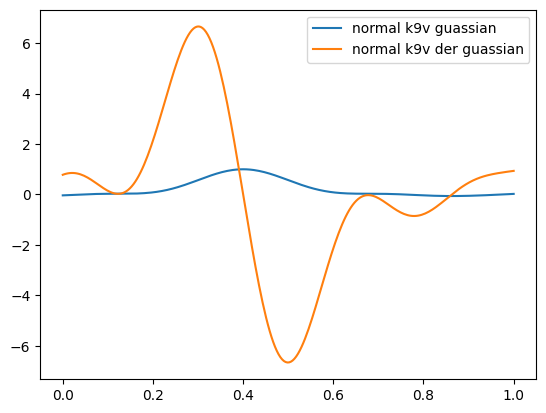

In [ ]:
#normal guassian using k9, not k8 which looks at zero boundaries
plt.plot(x0, k9v(x0, x_04), label = 'normal k9v guassian');
plt.plot(x0, k9v_der(x0, x_04), label = 'normal k9v der guassian');
plt.legend();

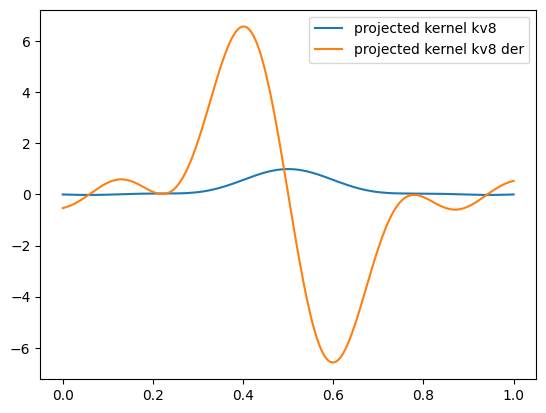

In [ ]:
##zero boundaries

plt.plot(x0,k8v(x0, x_05), label= 'projected kernel kv8');
plt.plot(x0,k8v_der(x0, x_05), label = 'projected kernel kv8 der');
plt.legend();

# alpha function using projected feature map

i.e. $\alpha(0) = 0= \alpha(1)$. $\beta$ must be length $(2 *$ numfeatures) - 2 for dimensions.

$\alpha(x) = \beta^T \gamma_0(x)$


In [ ]:
#beta_true is shorter by 2 dimensions
def alpha(t, x, b,
           Lambda_unitary = LU,
           fourier_sample = fourier_sample_gamma,
           feature_coeff = feature_coeff):
  return tf.linalg.matmul(tf.transpose(b), feature_map_0(x))

## alpha function input X as a matrix of vectors and Beta as matrix of betas


In [ ]:
def alpha_matrix(t, x, b):
  '''
  Args:
  t: a place holder, t = 1
  x: must be a matrix(n,d), n-dimensional vector, d how many vectors
  b: must be a matrix(98, d), how many vectors d for each x

  '''

  d = len(x[0])
  a_list = []
  for i in range(d):
    a_list.append(alpha(t, x[:,i:i+1], b[:,i:i+1]))
  m = tf.keras.layers.Concatenate(axis=0)(a_list)
  m = tf.cast(m, dtype = tf.float64)
  return m

In [ ]:
alpha_matrix(1, x0, beta_true).shape

TensorShape([1, 256])

In [ ]:
beta_true.shape

TensorShape([98, 1])

In [ ]:
beta_true_m = tf.broadcast_to(beta_true, (len(beta_true), 2))
print(beta_true_m.shape)

(98, 2)


In [ ]:
print(x0_m.shape)

(256, 2)


In [ ]:
alpha_matrix(1, x0_m, beta_true_m).shape

TensorShape([2, 256])

In [ ]:
alpha_matrix(1, x0_m, beta_true_m)[0:1,0:5]

<tf.Tensor: shape=(1, 5), dtype=float64, numpy=
array([[1.48220409e-17, 3.97524709e-04, 8.53447593e-04, 1.36471901e-03,
        1.92790059e-03]])>

In [ ]:
print(len(R_train_matrix[0]))
print(len(R_test_matrix[0]))

10
500


In [ ]:
print(x0.shape)
alpha_x0 = alpha(1, x0, beta_true)
print(alpha_x0.shape)

(256, 1)
(1, 256)


In [ ]:
alpha_x0_m = alpha_matrix(1, x0, beta_true)
print(alpha_x0_m.shape)

(1, 256)


In [ ]:
print(tf.transpose(alpha_x0).shape)
print(tf.transpose(alpha_x0_m).shape)
print(x0.shape)

(256, 1)
(256, 1)
(256, 1)


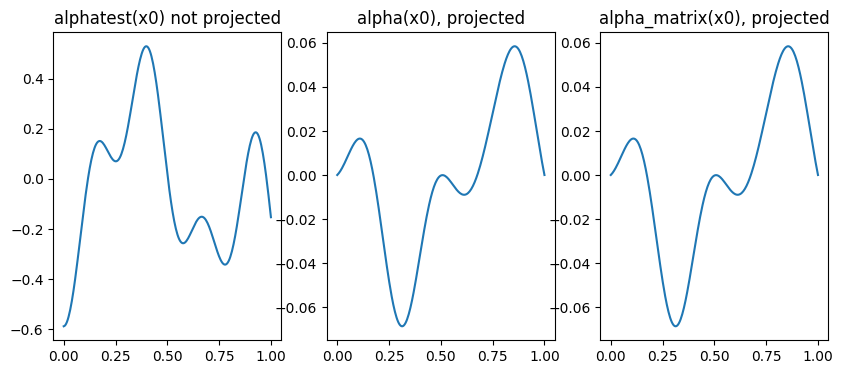

In [ ]:
# Create two subplots
fig, (f3, f4, f5) = plt.subplots(1, 3, figsize=(10, 4))

f3.plot(x0,  tf.transpose(alpha_fixed_x0), label = 'Alpha function alpha(x0)');
f3.set_title('alphatest(x0) not projected')
f4.plot(x0, tf.transpose(alpha_x0));
f4.set_title('alpha(x0), projected');
f5.plot(x0, tf.transpose(alpha_x0_m));
f5.set_title('alpha_matrix(x0), projected');


Test alpha derivative

$\frac{d}{dx} \alpha(x) = \beta^T \frac{d}{dx}\gamma_0(x)$

In [ ]:
def alpha_der(t, x, b,
           Lambda_unitary = LU,
           fourier_sample = fourier_sample_gamma,
           feature_coeff = feature_coeff):
  return tf.linalg.matmul(tf.transpose(b), feature_map_der_0(x))

In [ ]:
a_der = alpha_der(1, x0, beta_true)

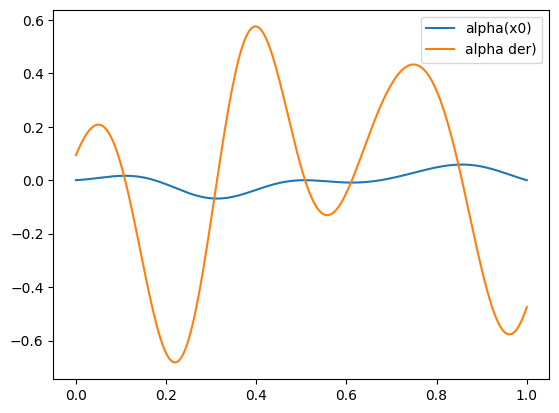

In [ ]:
# Create two subplots
#fig, (p5, p6) = plt.subplots(1, 2, figsize=(10, 4))


plt.plot(x0, tf.transpose(alpha_x0), label = 'alpha(x0)');
#p6.set_title('alpha(x_0)');
plt.plot(x0, tf.transpose(a_der), label = 'alpha der)');
#p5.set_title('alpha(sx0)')
plt.legend();


## Make time intervals for ODE



In [ ]:
# time intervals for my ODE integrator
num = 20
t_list = np.linspace(0, 1.0, num = num)
print(t_list)

[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]


## Euler formula for alpha

In [ ]:
# numpy euler for alpha function
def s_alpha(x, b, num = num, a = alpha):
  sa = np.zeros((len(x), num))
  x_t = np.reshape(x, (len(x),))
  sa[:,0] = x_t
  for i in range(1,num):
    x_t += 1/(num-1) * a(1, x, b)
    sa[:,i] = x_t
  return sa # (n, num) matrix array

In [ ]:
solalpha_test = s_alpha(x0, beta_true)

## Tensor flow Euler

In [ ]:
def s_alpha_tf(x, b, num = num, a_func = alpha):
    """
    TensorFlow version of the `s_alpha` function.

    Args:
    - x: Input tensor (n,).
    - b: Parameter for the `a_func`.
    - num: Number of columns in the output tensor.
    - a_func: A function that computes values based on alpha, x, and b.

    Returns:
    - A tensor of shape (n, num).
    """
    # Initialize the output tensor with zeros
    columns =[]
    columns.append(x)
    #print(x.dtype)

    # Assign the first column and keeping the rest zeros
    #sa = tf.keras.layers.Concatenate(axis=1)((x0,sa[:, 1:]))

    # Iteratively compute the remaining columns
    for i in range(1, num):
        x += (1 / (num - 1)) * tf.transpose(a_func(1, x, b))
        #print(x.dtype)
        columns.append(x)

    #print(columns)
    sa = tf.keras.layers.Concatenate(axis=1)(columns)
    sa = tf.cast(sa, dtype = tf.float64)
    return sa


In [ ]:
tf_euler_alpha = s_alpha_tf(x0, beta_true, num, alpha)

In [ ]:
'''
def s_alpha_tf_m(x, b, num = num, a_func = alpha):
    """
    TensorFlow version of the `s_alpha` function.

    Args:
    - x: Input tensor (n,).
    - b: Parameter for the `a_func`.
    - num: Number of columns in the output tensor.
    - a_func: A function that computes values based on alpha, x, and b.

    Returns:
    - A tensor of shape (n, num).
    """
    # Initialize the output tensor with zeros
    columns =[]
    columns.append(x)
    #print(x.dtype)

    # Assign the first column and keeping the rest zeros
    #sa = tf.keras.layers.Concatenate(axis=1)((x0,sa[:, 1:]))

    # Iteratively compute the remaining columns
    for i in range(1, num):
        x += (1 / (num - 1)) * tf.transpose(a_func(1, x, b))
        #print(x.dtype)
        columns.append(x)

    #print(columns)
    sa = tf.keras.layers.Concatenate(axis=1)(columns)
    sa = tf.cast(sa, dtype = tf.float64)
    return sa
'''

'\ndef s_alpha_tf_m(x, b, num = num, a_func = alpha):\n    """\n    TensorFlow version of the `s_alpha` function.\n\n    Args:\n    - x: Input tensor (n,).\n    - b: Parameter for the `a_func`.\n    - num: Number of columns in the output tensor.\n    - a_func: A function that computes values based on alpha, x, and b.\n\n    Returns:\n    - A tensor of shape (n, num).\n    """\n    # Initialize the output tensor with zeros\n    columns =[]\n    columns.append(x)\n    #print(x.dtype)\n\n    # Assign the first column and keeping the rest zeros\n    #sa = tf.keras.layers.Concatenate(axis=1)((x0,sa[:, 1:]))\n\n    # Iteratively compute the remaining columns\n    for i in range(1, num):\n        x += (1 / (num - 1)) * tf.transpose(a_func(1, x, b))\n        #print(x.dtype)\n        columns.append(x)\n\n    #print(columns)\n    sa = tf.keras.layers.Concatenate(axis=1)(columns)\n    sa = tf.cast(sa, dtype = tf.float64)\n    return sa\n'

In [ ]:
#tf_euler_matrix = s_alpha_tf(x0, b_beta_true, num, alpha)
#print(tf_euler_matrix.shape)

In [ ]:
print(tf_euler_alpha.shape)

(256, 20)


## Vectorized Euler Tensor flow


In [ ]:
def s_alpha_tf_m(x, b, num = num):
    """
    TensorFlow version of the `s_alpha` function.

    Args:
    - x: Input tensor (n,).
    - b: Parameter for the `a_func`.
    - num: Number of columns in the output tensor.
    - a_func: A function that computes values based on alpha, x, and b.

    - alpha_matrix(t, x, b, fourier_sample, feature_coeff)


    Returns:
    - A tensor of shape (n, d). n-dimensional vector,
      d how many vectors for t = 1
    """
    # Initialize the output tensor with zeros
    #columns =[]
    #columns.append(x)
    #print(x.dtype)

    # Assign the first column and keeping the rest zeros
    #sa = tf.keras.layers.Concatenate(axis=1)((x0,sa[:, 1:]))

    # Iteratively compute the remaining columns

    #a = alpha_matrix(1, x, b)
    #print(tf.transpose(a).shape)

    #print(x.shape)

    for i in range(1, num):

      x += (1 / (num - 1)) * tf.transpose(alpha_matrix(1, x, b))
      #print(x.shape)
      #print(x[0:5,:])
      #columns.append(x)

    #print(columns)

    return x


In [ ]:
#print((tf.transpose(alpha_matrix(1, x0_m3, beta_true_m)))[0:5,:])
#print(((1/(num-1)) * tf.transpose(alpha_matrix(1, x0_m3, beta_true_m)))[0:5,:])

In [ ]:
#print(x0_m2.dtype)
print(alpha_matrix(1, x0_m3, beta_true_m).shape)

(2, 256)


In [ ]:
print(x0_m[0:5,:])

tf.Tensor(
[[0.         0.        ]
 [0.00392157 0.00392157]
 [0.00784314 0.00784314]
 [0.01176471 0.01176471]
 [0.01568627 0.01568627]], shape=(5, 2), dtype=float64)


In [ ]:
s_alpha_tf_m(x0_m3, beta_true_m, num).shape

TensorShape([256, 2])

In [ ]:
big_b = tf.tile(beta_true, (len(beta_true[0]), len(N_test_matrix[0])* len(N_train_matrix[0])))
print(big_b.shape)

(98, 10000)


In [ ]:
X_Mat = tf.tile(x0, (len(x0[0]), len(N_test_matrix[0])* len(N_train_matrix[0])))
print(X_Mat.shape)
print(X_Mat[0:5, 0:5])
start_time = time.time()
euler_tf_m = s_alpha_tf_m(X_Mat, big_b)
end_time = time.time()
print(f"Time taken: {(end_time - start_time)/60} min")

(256, 10000)
tf.Tensor(
[[0.         0.         0.         0.         0.        ]
 [0.00392157 0.00392157 0.00392157 0.00392157 0.00392157]
 [0.00784314 0.00784314 0.00784314 0.00784314 0.00784314]
 [0.01176471 0.01176471 0.01176471 0.01176471 0.01176471]
 [0.01568627 0.01568627 0.01568627 0.01568627 0.01568627]], shape=(5, 5), dtype=float64)
Time taken: 11.823505727450053 min


In [ ]:

#alpha_euler_tf_intermidate = print(_)

In [ ]:
#print(_.shape)

In [ ]:
#alpha_euler_tf_intermidate = _

In [ ]:
euler_tf_m

<tf.Tensor: shape=(256, 10000), dtype=float64, numpy=
array([[1.54985731e-17, 1.54985731e-17, 1.54985731e-17, ...,
        1.54985731e-17, 1.54985731e-17, 1.54985731e-17],
       [4.34038977e-03, 4.34038977e-03, 4.34038977e-03, ...,
        4.34038977e-03, 4.34038977e-03, 4.34038977e-03],
       [8.74882900e-03, 8.74882900e-03, 8.74882900e-03, ...,
        8.74882900e-03, 8.74882900e-03, 8.74882900e-03],
       ...,
       [9.95222724e-01, 9.95222724e-01, 9.95222724e-01, ...,
        9.95222724e-01, 9.95222724e-01, 9.95222724e-01],
       [9.97593374e-01, 9.97593374e-01, 9.97593374e-01, ...,
        9.97593374e-01, 9.97593374e-01, 9.97593374e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])>

## ode_solver runga kutta

In [ ]:
rk_sol_alpha = solve_ivp(alpha,[0,1],
                      np.reshape(x0,len(x0)),
                      t_eval = t_list,
                      vectorized = True,
                      args =(beta_true, LU, fourier_sample_gamma, feature_coeff))

In [ ]:
print(rk_sol_alpha.y.shape)

(256, 20)


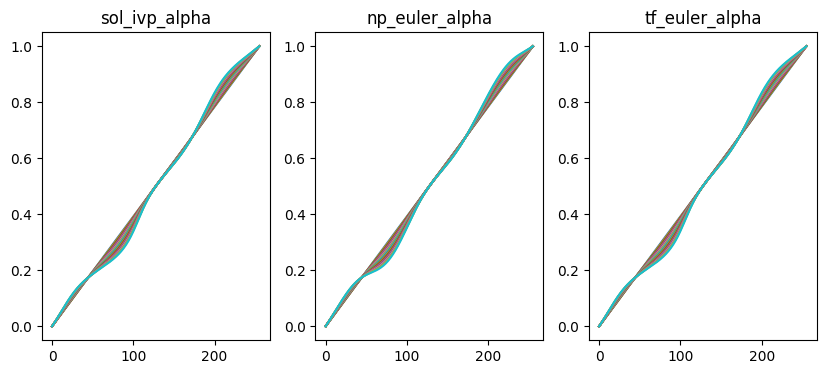

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.plot(rk_sol_alpha.y)
ax1.set_title('sol_ivp_alpha')
ax2.plot(solalpha_test);
ax2.set_title('np_euler_alpha')
ax3.plot(tf_euler_alpha);
ax3.set_title('tf_euler_alpha');

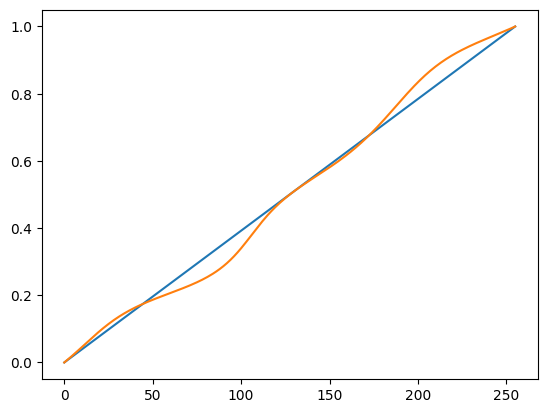

In [ ]:
plt.plot(x0)
plt.plot(euler_tf_m[:,-1]);

# Phi_1 interpolation
I need to interpolate to obtain phi_1.

In [ ]:
def linear_inter(x, xp, fp):
    """
    Use TensorFlow Probability's interpolation for 1D linear interpolation.
    Args:
        x: Tensor of query points.
        xp: List/Tensor of known x-coordinates (must be equally spaced).
        fp: List/Tensor of known y-coordinates.
    Returns:
        Tensor (n, 1) Interpolated values at query points `x`.
    """
    # Ensure xp is a regular grid
    xp = tf.convert_to_tensor(tf.squeeze(xp), dtype=tf.float64) #need 0-d
    fp = tf.convert_to_tensor(tf.squeeze(fp), dtype=tf.float64) #need 0-d

    # Ensure x is within the range of xp
    x_min, x_max = xp[0], xp[-1]
    x = tf.clip_by_value(x, x_min, x_max)

    # Use tfp interp_regular_1d_grid
    interpolated_values = tfp.math.interp_regular_1d_grid(
        x=x,
        x_ref_min=x_min,
        x_ref_max=x_max,
        y_ref=fp,
        axis=0
    )
    return interpolated_values


In [ ]:
linear_inter(x0, x0, tf.transpose(N_train_matrix[:,0:1])).shape

TensorShape([256, 1])

In [ ]:
b_x0 = tf.broadcast_to(x0, (len(x0), len(R_train_matrix[0]) * len(R_test_matrix[0])))
print(b_x0.shape)

(256, 5000)


In [ ]:
broad_cast = linear_inter(b_x0, x0, tf.transpose(N_train_matrix[:,0:1]))
print(broad_cast.shape)
print(broad_cast[0:5,0:5])


(256, 5000)
tf.Tensor(
[[0.08553439 0.08553439 0.08553439 0.08553439 0.08553439]
 [0.09525635 0.09525635 0.09525635 0.09525635 0.09525635]
 [0.09815844 0.09815844 0.09815844 0.09815844 0.09815844]
 [0.09972861 0.09972861 0.09972861 0.09972861 0.09972861]
 [0.10848908 0.10848908 0.10848908 0.10848908 0.10848908]], shape=(5, 5), dtype=float64)


In [ ]:
print(len(N_train_matrix[0]))
print(euler_tf_m.shape)
print(len(N_test_matrix[0]))

10
(256, 10000)
1000


In [ ]:
start_t = time.time()
list_p = []
for i in range(len(N_train_matrix[0])): # 10, it should go 1 by 1000, then 2 by 1000 to get to 10,000
  #print(i)
  p = linear_inter(euler_tf_m[:,i*len(N_test_matrix[0]) : (i +1)* len(N_test_matrix[0])] # there are 10 training (phiONE) vectors
                                                                            , x0
                                                                            , tf.transpose(N_train_matrix[:,i:(i +1)]))
  list_p.append(p)

BIG_est = tf.keras.layers.Concatenate(axis=1)(list_p)


end_t = time.time()
etime = end_t - start_t
print(f"Time taken: {etime} sec")

Time taken: 0.42209410667419434 sec


In [ ]:
print(BIG_est.shape)

(256, 10000)


In [ ]:
print(N_test_matrix.shape)

(256, 1000)


In [ ]:
BIG_PHI0 = tf.tile(N_test_matrix, [1,10])
BIG_PHI0 = tf.cast(BIG_PHI0, dtype = tf.float64)
BIG_est = tf.cast(BIG_est, dtype = tf.float64)

In [ ]:
print(BIG_PHI0.shape)
print(BIG_PHI0[0:5, 0:2])
print(BIG_PHI0[0:5, 1000:1002])
print(BIG_PHI0[0:5, 2000:2002])

(256, 10000)
tf.Tensor(
[[0.28048003 0.45308901]
 [0.26532939 0.47585936]
 [0.25661725 0.50293683]
 [0.25235493 0.52576477]
 [0.25157607 0.53689608]], shape=(5, 2), dtype=float64)
tf.Tensor(
[[0.28048003 0.45308901]
 [0.26532939 0.47585936]
 [0.25661725 0.50293683]
 [0.25235493 0.52576477]
 [0.25157607 0.53689608]], shape=(5, 2), dtype=float64)
tf.Tensor(
[[0.28048003 0.45308901]
 [0.26532939 0.47585936]
 [0.25661725 0.50293683]
 [0.25235493 0.52576477]
 [0.25157607 0.53689608]], shape=(5, 2), dtype=float64)


In [ ]:
print(BIG_est.dtype)
print(BIG_PHI0.dtype)

<dtype: 'float64'>
<dtype: 'float64'>


In [ ]:
phi_d = tf.math.squared_difference(BIG_est,BIG_PHI0)
# this give a tensor of (10 * len(phinot[0]))
summ = tf.reduce_sum(phi_d, axis = 0)
print(summ.shape)

(10000,)


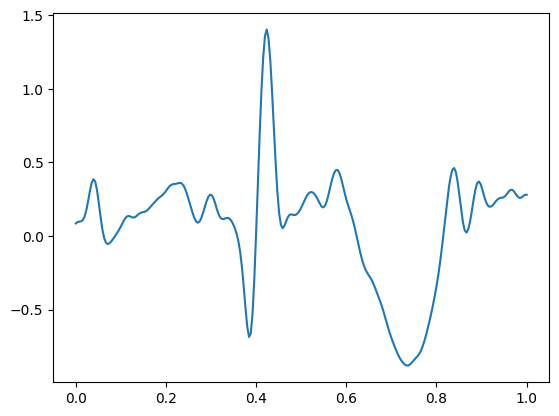

In [ ]:
plt.plot(x0, broad_cast[:,0:1])

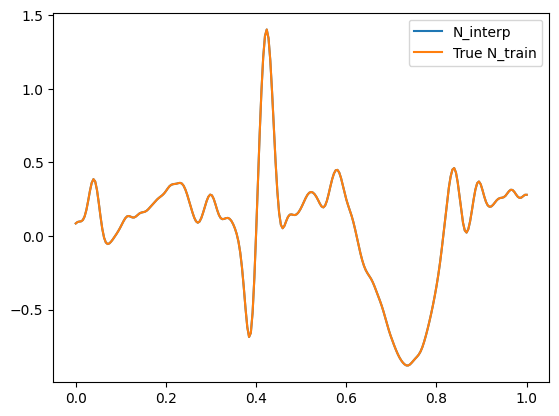

In [ ]:
plt.plot(x0, linear_inter(x0, x0, tf.transpose(N_train_matrix[:,0:1])), label = 'N_interp')
plt.plot(x0, N_train_matrix[:,0:1], label = 'True N_train');
plt.legend(prop={'size':10});

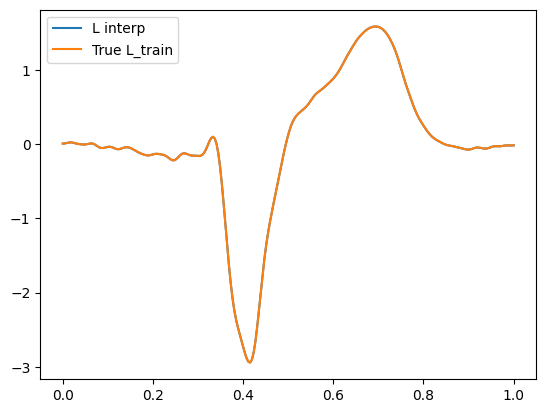

In [ ]:
plt.plot(x0, linear_inter(x0, x0, tf.transpose(L_train_matrix[:,0:1])), label = 'L interp')
plt.plot(x0, L_train_matrix[:,0:1], label = 'True L_train');
plt.legend(prop={'size':10});

## Derivative of phi_1 interpolation

### autodiff

In [ ]:
phix_arr = tf.Variable(x0)
with tf.GradientTape() as tape:
  tape.watch(phix_arr)
  y = linear_inter(phix_arr, x0, tf.transpose(N_train_matrix[:,0:1]))
N_train_der_tf_li = tape.gradient(y, phix_arr)

### finite difference forward

In [ ]:
epsilon_f = 1e-2
# Finite Differences, forward for EKG
def der_forward_EKG(func, x, epsilon, y, matrix):
    perturbed_x = x + epsilon
    perturbed_output = func(perturbed_x, y, matrix)
    base_output = func(x, y, matrix)
    return (perturbed_output - base_output) / epsilon

In [ ]:
N_train_der_fd = der_forward_EKG(linear_inter, x0, epsilon_f, x0, tf.transpose(N_train_matrix[:,0:1]))

### finite difference central

In [ ]:
epsilon_c = 1e-7
# Finite Differences, cetnal differnece which is 2nd order for EKG
def numerical_derivative_central_EKG(func, x, epsilon, y , matrix):
    perturbed_x_plus = x + epsilon
    perturbed_x_minus = x - epsilon
    perturbed_output_plus = func(perturbed_x_plus,  y, matrix)
    perturbed_output_minus = func(perturbed_x_minus,  y, matrix)
    return (perturbed_output_plus - perturbed_output_minus) / (2 * epsilon)

In [ ]:
N_train_der_central = numerical_derivative_central_EKG(lambda x, y, matrix: linear_inter(x, y, matrix),
                                                        x0,
                                                        epsilon_c,
                                                        x0,
                                                        tf.transpose(N_train_matrix[:,0:1]))

### Drawing of derivatives.

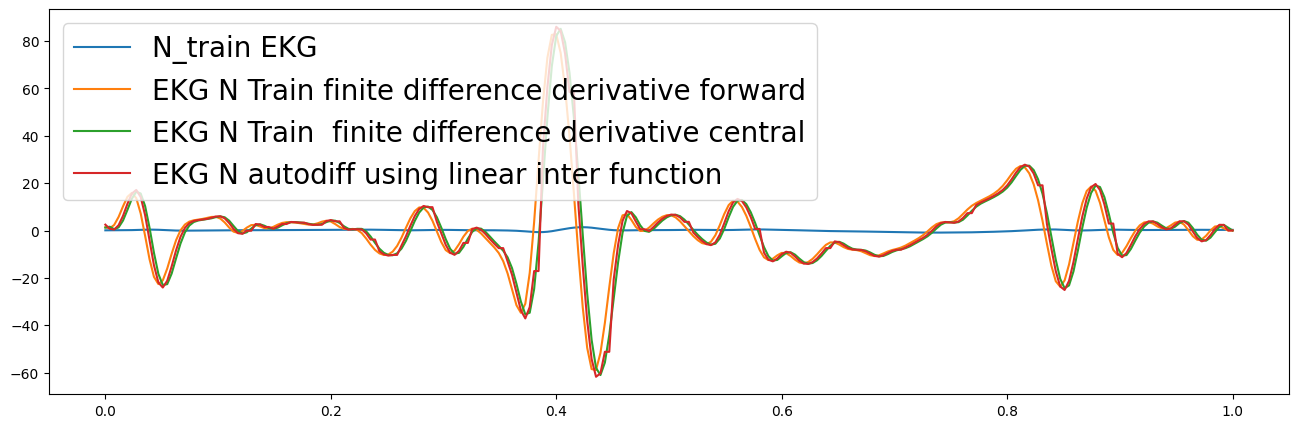

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(x0, linear_inter(x0, x0, tf.transpose(N_train_matrix[:,0:1])), label = 'N_train EKG');
plt.plot(x0, N_train_der_fd, label = 'EKG N Train finite difference derivative forward')
plt.plot(x0, N_train_der_central, label = 'EKG N Train  finite difference derivative central')
plt.plot(x0, N_train_der_tf_li, label = 'EKG N autodiff using linear inter function ')
plt.legend(prop={'size':20});

# Objective function

$$ J_i(\beta) = \psi_i(\beta^T \gamma(\cdot), x_0) + \lambda \beta^T \beta$$
Where
$$\psi_i(\beta^T \gamma(\cdot), x_0) = \left( \phi_0(x_i(1)) - \phi_0(x_i(0))\right)^2$$
And
$$ \psi(\beta^T \gamma(\cdot),x_0) = \frac{1}{n} \sum_{i=1}^n \psi_i(\beta^T \gamma(\cdot),x_0) $$
So
\begin{align}
J(\beta)
& = \frac{1}{n} \sum_{i=1}^n  \left( \phi_0(x_i(0)) - \phi_0(x_i(1))\right)^2 +\lambda \beta^T \beta
\end{align}

In [ ]:
def J_obj(b, x = x0, LAM = .00001, phi0fixed = N_test_matrix[:,0:1], phi1fixed = N_train_matrix[:,0:1]):
  '''
  Args:
  (x_t1: estimated x @ time 1)
  x: initial trajectories at time = 0
  b: beta vector
  s_alpha_tf: tensor flow eulers for alpha, output is (n,num)
  LAM: lambda
  phi1 function: phi1 or linear_inter
  phi0fixed: the testing data from data
  phi1fixed: for the phi1 interpolatiion function
  '''
  # Eulers tensfor flow function to obtain trajectories
  x_traj = s_alpha_tf(x, b, num = num, a_func = alpha)

  # Obtain trajectory at time=1 from Euler's method, last column in x_traj
  xt1 = tf.reshape(x_traj[:,-1], (len(x_traj),1))

  # Ensure x_t1, phi0fixed, phi1fixed, b are TensorFlow tensors
  xt1 = tf.convert_to_tensor(xt1, dtype=tf.float64)
  phi0fixed = tf.convert_to_tensor(phi0fixed, dtype=tf.float64)
  phi1fixed = tf.convert_to_tensor(phi1fixed, dtype=tf.float64)
  b = tf.convert_to_tensor(b, dtype=tf.float64)

  # estimate of phi1 using linear interpolation using tensor flow
  phi1_est = linear_inter(xt1, x, tf.transpose(phi1fixed))
  # make sure we stay in tf.float64
  phi1_est = tf.cast(phi1_est, dtype=tf.float64)
  #phi1_est = phi1(x_t1, x0, tf.transpose(phi1fixed))
  #print(phi1_est.shape)
  phi_diff = tf.math.squared_difference(phi1_est,phi0fixed)
  #phi_diff = (phi1_est - phi0fixed)**2
  #print(phi_diff.shape)
  summ = tf.reduce_sum(phi_diff, axis = 0)
  #print(summ)
  #print(len(xt1))
  # namke n a ft.float64
  n = tf.cast(len(xt1), dtype=tf.float64)
  #summ = tf.cast(summ, dtype=tf.float64)
  obj = ((1/(n)) * summ) + (LAM * tf.transpose(b) @ b)
  return obj

In [ ]:
J_obj(beta_true)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.13623404]])>

In [ ]:
#J_obj(b = beta_true, x = sx0, LAM = .00001,  phi0fixed = N_test_sub[:,0:1], phi1fixed = N_train_sub[:,0:1])

In [ ]:
J_obj(beta_true)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.13623404]])>

## Try objective in a vectorized way
\begin{align}
J(\beta)
& = \frac{1}{n} \sum_{i=1}^n  \left( \phi_0(x_i(1)) - \phi_0(x_i(0))\right)^2 +\lambda \beta^T \beta
\end{align}

In [ ]:
def J_obj_m(b_m, x = x0, LAM = .00001, phi0fixed = N_test_matrix, phi1fixed = N_train_matrix):
  '''
  Args:
  (x_t1: estimated x @ time 1)
  x: initial trajectories at time = 0
  b: beta matrix
  '''
  # change x0 to a matrix so it can start in euler
  # x0 is a vector (256,1), x0 matrix is (256, 10 * 1000)
  # since we will be comparing 10 train to the amount of
  # vectors in test
  X_M = tf.tile(x, (len(x[0]), len(phi0fixed[0])* len(phi1fixed[0])))
  #print(X_M.shape)
  #print(X_M[0:5, 0:5])
  # Eulers tensfor flow function to obtain trajectories
  # this will be t @ 1 for all trajectories
  # b_m will change
  x_traj_m = s_alpha_tf_m(X_M, b_m, num = num)
  #print(x_traj_m.shape)
  #print(x_traj_m[0:5, 0:5])

  # now i have all my first x_traj for ALL my combo's
  #
  mat = []
  #BIG_PH1_est = tf.zeros([256, len(phi0fixed[0])* len(phi1fixed[0])])
  for i in range(len(phi1fixed[0])): # 10, it should go 1 by 1000, then 2 by 1000 to get to 10,000
    #print(i)
    p = linear_inter(x_traj_m[:,i*len(phi0fixed[0]) : (i +1)* len(phi0fixed[0])] # there are 10 training (phiONE) vectors
                                                                            , x
                                                                            , tf.transpose(phi1fixed[:,i:(i +1)]))
    mat.append(p)

  BIG_PHI_est = tf.keras.layers.Concatenate(axis=1)(mat)
  BIG_PHI_est = tf.cast(BIG_PHI_est , dtype = tf.float64)
  #print(f'BIG_PHI_est shape: {BIG_PHI_est.shape}')

  BIG_PHI_NOT = tf.tile(phi0fixed, [1,len(phi1fixed[0])]) #10 for the whole phione matrix
  #BIG_PHI_NOT = tf.tile(phi0fixed, [1,10])
  BIG_PHI_NOT = tf.cast(BIG_PHI_NOT , dtype = tf.float64)
  #print(f'BIG_PHI_NOT shape: {BIG_PHI_NOT.shape}')

  phi_diff = tf.math.squared_difference(BIG_PHI_est,BIG_PHI_NOT)
  #print(f'phi_diff shape: {phi_diff.shape}')
  # this give a tensor of (10 * len(phinot[0]))
  summ = tf.reduce_sum(phi_diff, axis = 0)
  #print(f'summ of phi_diff: {summ.shape}')



  n = (len(X_M) * len(X_M[0]))
  n = tf.cast(n, dtype=tf.float64)
  beta_term = tf.reduce_sum((b_m * b_m), axis = 0)
  #print(f'beta_term shape: {beta_term.shape}')
  obj = ((1/(n)) * summ) + (LAM * beta_term)
  #need to add lam * (sum) (B haddamard B)
  return obj



In [ ]:
big_beta = tf.tile(beta_true, [len(beta_true[0]),len(N_test_matrix[0])* len(N_train_matrix[0])])
big_beta.shape

TensorShape([98, 10000])

In [ ]:
X_M = tf.tile(x0, (len(x0[0]), len(N_test_matrix[0]) * len(N_train_matrix[0])))

In [ ]:
X_M.shape

TensorShape([256, 10000])

In [ ]:
euler_tf_m.shape

TensorShape([256, 10000])

In [ ]:
len( N_train_matrix[0])

10

In [ ]:
print(N_test_matrix.shape)

(256, 1000)


In [ ]:
linear_inter(euler_tf_m[:,i*len(N_test_matrix[0]) : (i + 1)* len(N_test_matrix[0])]
                                                                            , x0
                                                                            , tf.transpose(N_train_matrix[:, 0:1]))

<tf.Tensor: shape=(256, 1000), dtype=float64, numpy=
array([[0.08553439, 0.08553439, 0.08553439, ..., 0.08553439, 0.08553439,
        0.08553439],
       [0.09556629, 0.09556629, 0.09556629, ..., 0.09556629, 0.09556629,
        0.09556629],
       [0.09852107, 0.09852107, 0.09852107, ..., 0.09852107, 0.09852107,
        0.09852107],
       ...,
       [0.27792989, 0.27792989, 0.27792989, ..., 0.27792989, 0.27792989,
        0.27792989],
       [0.27996913, 0.27996913, 0.27996913, ..., 0.27996913, 0.27996913,
        0.27996913],
       [0.27999354, 0.27999354, 0.27999354, ..., 0.27999354, 0.27999354,
        0.27999354]])>

In [ ]:
mat = []
for i in range(len(N_train_matrix[0])): # 10, it should go 1 by 1000, then 2 by 1000 to get to 10,000
  print(i)
  p = linear_inter(euler_tf_m [:,i*len(N_test_matrix[0]) : (i + 1)* len(N_test_matrix[0])]
                                                                            , x0
                                                                            , tf.transpose(N_train_matrix[:, i:i+1]))
  mat.append(p)

BIG_PHI_est = tf.keras.layers.Concatenate(axis=1)(mat)
BIG_PHI_est = tf.cast(BIG_PHI_est , dtype = tf.float64)

0
1
2
3
4
5
6
7
8
9


In [ ]:
BIG_PHI_est

<tf.Tensor: shape=(256, 10000), dtype=float64, numpy=
array([[0.08553439, 0.08553439, 0.08553439, ..., 0.25545371, 0.25545371,
        0.25545371],
       [0.09556629, 0.09556629, 0.09556629, ..., 0.282543  , 0.282543  ,
        0.282543  ],
       [0.09852108, 0.09852108, 0.09852108, ..., 0.30586568, 0.30586568,
        0.30586568],
       ...,
       [0.2779299 , 0.2779299 , 0.2779299 , ..., 0.28987667, 0.28987667,
        0.28987667],
       [0.27996913, 0.27996913, 0.27996913, ..., 0.25699794, 0.25699794,
        0.25699794],
       [0.27999353, 0.27999353, 0.27999353, ..., 0.22069959, 0.22069959,
        0.22069959]])>

In [ ]:
BIG_PHI_NOT = tf.tile(N_test_matrix, [1, 10])
print(BIG_PHI_NOT.shape)
(BIG_PHI_est - BIG_PHI_NOT)**2

(256, 10000)


<tf.Tensor: shape=(256, 10000), dtype=float64, numpy=
array([[3.80038020e-02, 1.35096399e-01, 6.60909744e-02, ...,
        5.47099988e-05, 1.83993082e-02, 3.86069693e-01],
       [2.88195126e-02, 1.44622819e-01, 6.27796104e-02, ...,
        1.40211793e-03, 7.05962165e-03, 4.04694096e-01],
       [2.49943993e-02, 1.63552099e-01, 5.85430199e-02, ...,
        4.11128258e-03, 1.19158228e-03, 3.91192305e-01],
       ...,
       [8.63440251e-03, 9.57604280e+00, 4.37395887e-03, ...,
        6.70660255e-04, 1.10407993e+00, 2.85269750e-02],
       [1.19105790e-02, 1.33383116e+01, 4.92306564e-03, ...,
        1.42443059e-03, 1.87806411e+00, 1.52705793e-02],
       [1.33423854e-02, 1.79963105e+01, 5.37055314e-03, ...,
        3.13439390e-03, 2.88031621e+00, 7.15038411e-03]])>

In [ ]:
phi_diff = tf.math.squared_difference(BIG_PHI_est,BIG_PHI_NOT)
print(phi_diff)

tf.Tensor(
[[3.80038020e-02 1.35096399e-01 6.60909744e-02 ... 5.47099988e-05
  1.83993082e-02 3.86069693e-01]
 [2.88195126e-02 1.44622819e-01 6.27796104e-02 ... 1.40211793e-03
  7.05962165e-03 4.04694096e-01]
 [2.49943993e-02 1.63552099e-01 5.85430199e-02 ... 4.11128258e-03
  1.19158228e-03 3.91192305e-01]
 ...
 [8.63440251e-03 9.57604280e+00 4.37395887e-03 ... 6.70660255e-04
  1.10407993e+00 2.85269750e-02]
 [1.19105790e-02 1.33383116e+01 4.92306564e-03 ... 1.42443059e-03
  1.87806411e+00 1.52705793e-02]
 [1.33423854e-02 1.79963105e+01 5.37055314e-03 ... 3.13439390e-03
  2.88031621e+00 7.15038411e-03]], shape=(256, 10000), dtype=float64)


In [ ]:
summ = tf.reduce_sum(phi_diff, axis = 0)
print(summ)

tf.Tensor(
[ 34.87563245 103.90248835  68.37551693 ...  37.80495587  66.21459256
  54.34498699], shape=(10000,), dtype=float64)


In [ ]:
print(len(X_M[0]))
print(len(X_M))
print(X_M.shape)
(len(X_M) *len(X_M[0]))

10000
256
(256, 10000)


2560000

In [ ]:
beta_true_m[0:5, :]

<tf.Tensor: shape=(5, 2), dtype=float64, numpy=
array([[ 0.01559975,  0.01559975],
       [-0.01169803, -0.01169803],
       [ 0.08594074,  0.08594074],
       [-0.0089128 , -0.0089128 ],
       [ 0.00387529,  0.00387529]])>

In [ ]:
(beta_true_m * beta_true_m)[0:5, :]

<tf.Tensor: shape=(5, 2), dtype=float64, numpy=
array([[2.43352119e-04, 2.43352119e-04],
       [1.36843822e-04, 1.36843822e-04],
       [7.38581070e-03, 7.38581070e-03],
       [7.94380523e-05, 7.94380523e-05],
       [1.50178967e-05, 1.50178967e-05]])>

In [ ]:
(.0001 * tf.reduce_sum(beta_true_m * beta_true_m, axis =0)).shape

TensorShape([2])

In [ ]:
(big_beta * big_beta).shape

TensorShape([98, 10000])

In [ ]:
(tf.reduce_sum(big_beta * big_beta, axis = 0)).shape

TensorShape([10000])

In [ ]:
s_t = time.time()
BIGOBJ = J_obj_m(big_beta
        , x = x0
        , LAM = .00001
        , phi0fixed = N_test_matrix
        , phi1fixed = N_train_matrix)
e_t = time.time()
print(f'elapsted time: {(e_t - s_t)/60} min')

(256, 10000)
(256, 10000)
BIG_PHI_est shape: (256, 10000)
BIG_PHI_NOT shape: (256, 10000)
phi_diff shape: (256, 10000)
summ of phi_diff: (10000,)
beta_term shape: (10000,)
elapsted time: 11.696312050024668 min


In [ ]:
print(BIGOBJ.shape)
print(BIGOBJ[0:5])

(10000,)
tf.Tensor(
[1.36232939e-05 4.05869095e-05 2.67091863e-05 2.54457555e-05
 2.71550934e-05], shape=(5,), dtype=float64)


In [ ]:
s_t = time.time()
smallOBJ = J_obj_m(beta_true
        , x = x0
        , LAM = .00001
        , phi0fixed = N_test_matrix[:,0:1]
        , phi1fixed = N_train_matrix[:,0:1])
e_t = time.time()
print(f'elapsted time: {(e_t - s_t)/60} min')

elapsted time: 0.0024965365727742514 min


In [ ]:
smallOBJ

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.13623403])>

## Squared difference function

\begin{align}
J_1(\beta)
& = \frac{1}{n} \sum_{i=1}^n  \left( \phi_0(x_i(1)) - \phi_0(x_i(0))\right)^2
\end{align}

In [ ]:
def J1_obj(x, b, phi0fixed = N_test_matrix[:,0:1], phi1fixed = N_train_matrix[:,0:1]):
  '''
 (x_t1: estimated x @ time 1)
  x: initial trajectories at time = 0
  b: beta vector
  s_alpha_tf: tensor flow eulers for alpha, output is (n,num)
  phi1 function: phi1 or linear_inter
  phi0fixed: the testing data from data
  phi1fixed: for the phi1 interpolation function
  '''
  # Eulers tensfor flow function to obtain trajectories
  x_traj = s_alpha_tf(x, b, num = num, a_func = alpha)

  # Obtain trajectory at time=1 from Euler's method
  xt1 = tf.reshape(x_traj[:,-1], (len(x_traj),1))

  # Ensure x_t1 and phi0fixed are TensorFlow tensors
  xt1 = tf.convert_to_tensor(xt1, dtype=tf.float64)
  phi0fixed = tf.convert_to_tensor(phi0fixed, dtype=tf.float64)
  phi1fixed = tf.convert_to_tensor(phi1fixed, dtype=tf.float64)
  b = tf.convert_to_tensor(b, dtype=tf.float64)

  phi1_est = linear_inter(xt1, x, tf.transpose(phi1fixed))
  phi1_est = tf.cast(phi1_est, dtype=tf.float64)
  #phi1_est = phi1(x_t1, x0, tf.transpose(phi1fixed))
  #print(phi1_est.shape)
  phi_diff = tf.math.squared_difference(phi1_est,phi0fixed)
  #phi_diff = (phi1_est - phi0fixed)**2
  #print(phi_diff.shape)
  summ = tf.reduce_sum(phi_diff, axis = 0)
  #print(summ)
  #print(len(xt1))
  n = tf.cast(len(xt1), dtype=tf.float64)
  #summ = tf.cast(summ, dtype=tf.float64)
  obj = ((1/(n)) * summ)
  return obj

In [ ]:
J1_obj(x0, beta_true)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.13623295])>

In [ ]:
J1_obj(sx0, beta_true, phi0fixed = N_test_sub[:,0:1], phi1fixed = N_train_sub[:,0:1])

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.12845716])>

## Beta difference function

\begin{align}
J_2(\beta)
& = \lambda \beta^T \beta
\end{align}

In [ ]:
def J2(b, LAM = .00001):
  lbeta = (LAM * tf.transpose(b) @ b)
  return lbeta

In [ ]:
J2(beta_true)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.08769693e-06]])>

# Gradient Descent

## initialize beta

In [ ]:
# prompt: generate a vector close to zero but not zero using random selectiion mean, sd
np.random.seed(3)
# Set mean and standard deviation close to zero
mean = 0.001
sd = 0.001

# Generate a vector of random numbers with the specified mean and standard deviation
b_ini = np.random.normal(mean, sd, ((num_features*2)-2,1))  # Replace 10 with the desired vector length
#b_ini = tf.zeros(shape = (len(sx0)-2,1), dtype = tf.float64)

b_ini = tf.constant(b_ini, dtype=tf.float64)

#print(b_ini
print(b_ini.shape)


(98, 1)


# Gradient Descent with BIG obj function


In [ ]:
b_ini_m = tf.tile(b_ini, [len(b_ini[0]),len(N_test_matrix[0])* len(N_train_matrix[0])])
print(b_ini_m.shape)

(98, 10000)


In [ ]:
#test, checking lr
iter = 6 #
BETA = tf.Variable(b_ini_m)

lr = 1/(2**11)
print(f'learning rate {lr}')
LAMBDA = 1e-4


optimizer = tf.keras.optimizers.SGD(lr)
#label phi1 and phi0
phione = R_train_matrix
phinot = R_test_matrix


start_time = time.time()

for batch in range(iter):

  with tf.GradientTape() as tape:
    obj = J_obj_m(BETA, x = x0, LAM = .00001, phi0fixed = phinot, phi1fixed = phione)

  grad = tape.gradient(obj, BETA)
  optimizer.apply_gradients([(grad, BETA)])

  obj_new = J_obj_m(BETA, x = x0, LAM = .00001, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new[0]}')
  #obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze




  # store sq_Dist
  #sq_dist = J1_obj(x0, BETA, phi0fixed = phinot, phi1fixed = phione) #N_train_matrix[:,0:1])
  #sq_dist_values.append(np.squeeze(sq_dist))
  #print(f' batch: {batch}, squared_distance: {sq_dist}')

  # store beta_change
  #beta_change = J2(BETA, LAMBDA)
  #beta_change_values.append(np.squeeze(beta_change))
  #print(f' batch: {batch}, beta_change: {beta_change}')

  # Store grad norms
  #grad_norm = tf.norm(grad)
  #gradient_norms.append(grad_norm)
  #print(f'batch: {batch}, grad norm: {grad_norm}')


  # Store the values for plotting
  #iterations.append(batch)





end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec");

learning rate 0.00048828125


## Loop using old objective function



### L versus L

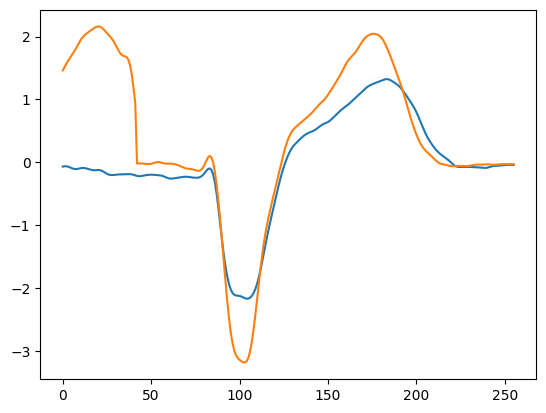

In [ ]:
plt.plot(L_train_matrix[:,4:5])
plt.plot(L_test_matrix[:,0:1])

In [ ]:
print(1e-3)
print(1/(2**8))

0.001
0.00390625


In [ ]:
iter = 6
BETA = b_ini
lr = 1/(2**8)
#print(f'learning rate {lr}')
LAMBDA = tf.constant(1e-5, dtype=tf.float64)

phione = L_train_matrix[:,4:5]
phinot = L_test_matrix[:,0:1]

obj_values = []
iterations = []
gradient_norms = []

start_time = time.time()

for batch in range(iter):
  #print(f'learning rate {lr}')
  BETA = tf.Variable(BETA)
  with tf.GradientTape() as tape:
    tape.watch(BETA)
    obj = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

  beta_grad = tape.gradient(obj, BETA)

  BETA = BETA - lr * beta_grad
  obj_new = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new}')

  # Store the values for plotting
  obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze
  iterations.append(batch)

#print(f'batch: {batch}, loss: {obj_new}')
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec")
#J_obj(b, x = x0, LAM = .00001, phi0fixed = N_test_matrix[:,0:1], phi1fixed = N_train_matrix[:,0:1]):


batch: 0, new objective: [[0.77858962]]
batch: 1, new objective: [[0.77279899]]
batch: 2, new objective: [[0.76843107]]
batch: 3, new objective: [[0.76503244]]
batch: 4, new objective: [[0.76222472]]
batch: 5, new objective: [[0.75990268]]
Elapsed time: 5.723686456680298 sec


### L versus L Subsampling

In [ ]:
# Subsampling
iter = 6
BETA = b_ini
lr = 1/(2**8)
#print(f'learning rate {lr}')
LAMBDA = tf.constant(1e-5, dtype=tf.float64)

phione = L_train_sub[:,4:5]
phinot = L_test_sub[:,0:1]

obj_values = []
iterations = []
gradient_norms = []

start_time = time.time()

for batch in range(iter):
  #print(f'learning rate {lr}')
  BETA = tf.Variable(BETA)
  with tf.GradientTape() as tape:
    tape.watch(BETA)
    obj = J_obj(BETA, x = sx0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

  beta_grad = tape.gradient(obj, BETA)

  BETA = BETA - lr * beta_grad
  obj_new = J_obj(BETA, x = sx0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new}')

  # Store the values for plotting
  obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze
  iterations.append(batch)

#print(f'batch: {batch}, loss: {obj_new}')
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec")
#J_obj(b, x = x0, LAM = .00001, phi0fixed = N_test_matrix[:,0:1], phi1fixed = N_train_matrix[:,0:1]):


batch: 0, new objective: [[0.79593549]]
batch: 1, new objective: [[0.79244047]]
batch: 2, new objective: [[0.78716835]]
batch: 3, new objective: [[0.78530638]]
batch: 4, new objective: [[0.78056546]]
batch: 5, new objective: [[0.77958313]]
Elapsed time: 5.6647398471832275 sec


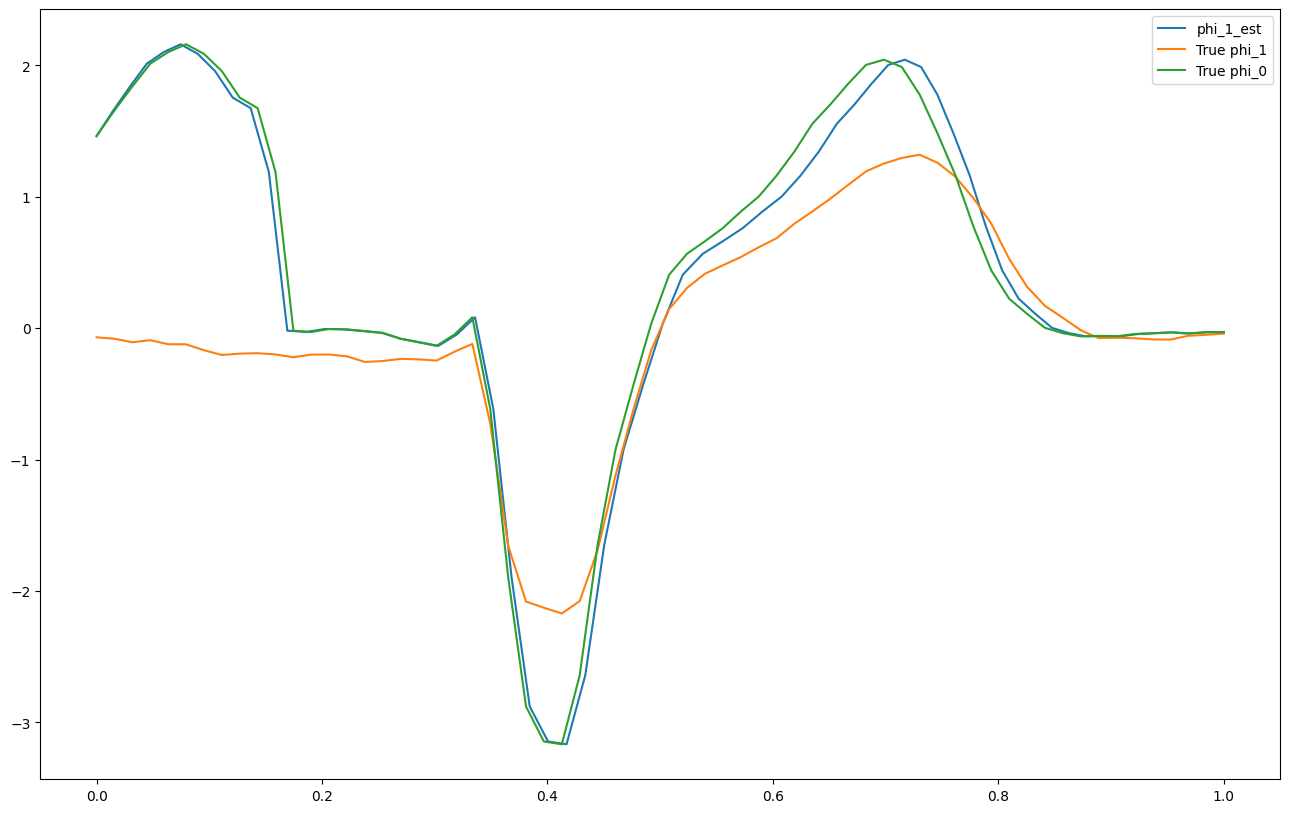

In [ ]:
plt.figure(figsize=(16,10))
x_traj = s_alpha_tf(sx0, BETA)
plt.plot(np.reshape(x_traj[:,-1], (len(sx0),1)),  phinot, label = 'phi_1_est')
plt.plot(sx0, phione, label = 'True phi_1')
plt.plot(sx0, phinot, label = 'True phi_0')
plt.legend();

### compare to DTW

In [ ]:
start_time = time.time()

alig = dtw(phione, phinot)

print(f' DTW distance: {alig.distance}')
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec")



 DTW distance: 34.76254933742549
Elapsed time: 0.009983062744140625 sec


### Loop: L with N with audtodiff for gradient

learning rate 0.00390625
batch: 0, new objective: [[2.16207334]]
batch: 0, grad norm: 11.056440266132746
batch: 1, new objective: [[2.03668636]]
batch: 1, grad norm: 6.499852633301776
batch: 2, new objective: [[1.94149426]]
batch: 2, grad norm: 5.072528194533097
batch: 3, new objective: [[1.8504388]]
batch: 3, grad norm: 4.913685305487435
batch: 4, new objective: [[1.76469592]]
batch: 4, grad norm: 4.679979806532035
batch: 5, new objective: [[1.68108358]]
batch: 5, grad norm: 4.654836175106912
Elapsed time: 6.52262544631958 sec


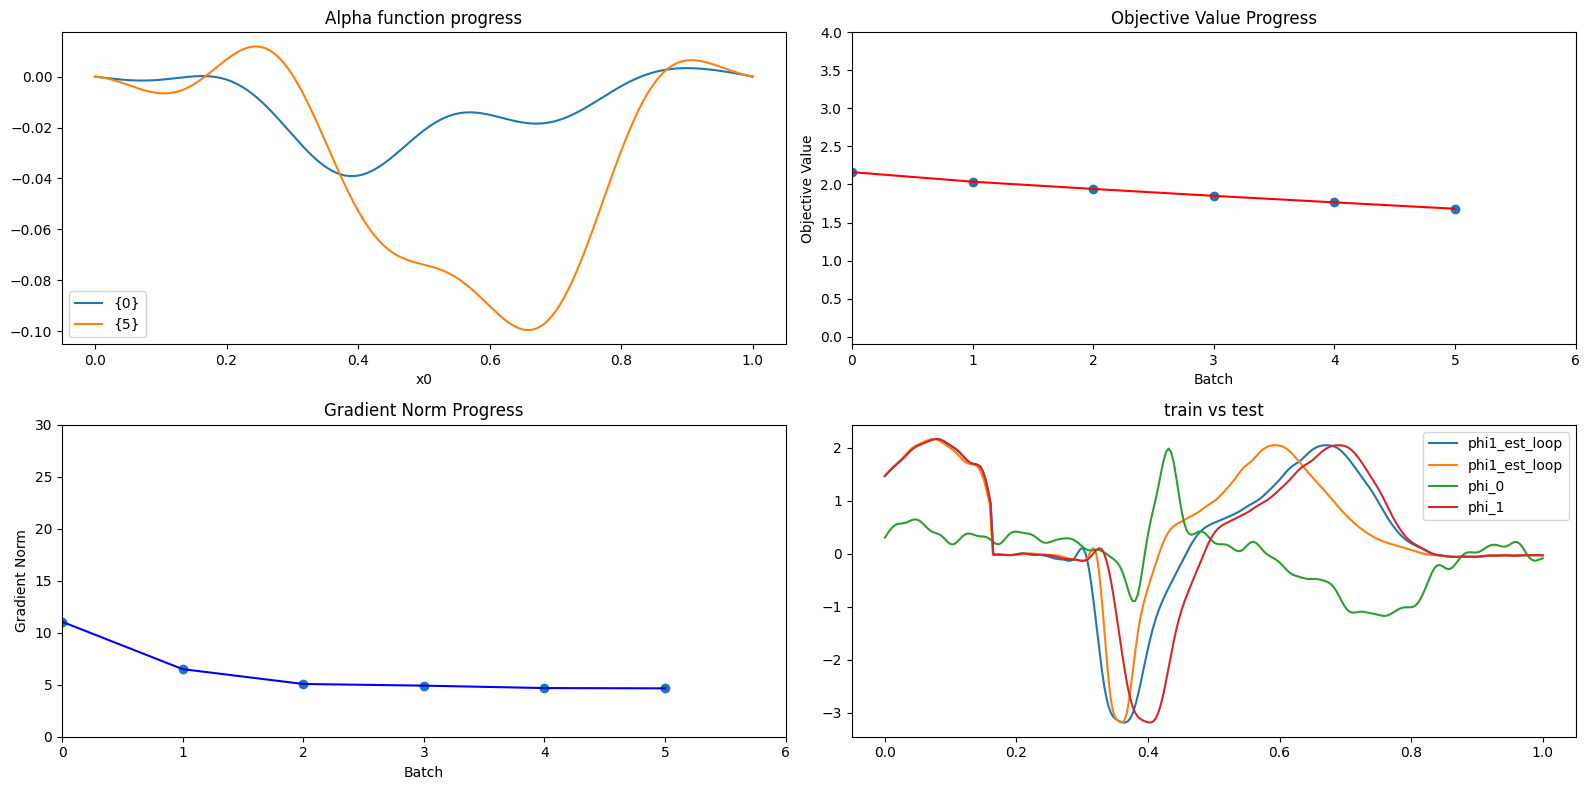

In [ ]:
iter = 6 #
BETA = tf.Variable(b_ini)
#BETA = beta_true
#lr = 1e-3
# lr = 1e-2
#lr = .0115
lr = 1/(2**8)
print(f'learning rate {lr}')
LAMBDA = 1e-5

#label phi1 and phi0
phione = N_train_matrix[:,4:5]
phinot = L_test_matrix[:,0:1]

fig, ((fig1, fig2), (fig3, fig4)) = plt.subplots(2, 2, figsize=(16, 8))


# Set x-axis limits to keep it the same throughout the loop
fig2.set_xlim(0, iter)
fig2.set_ylim(-0.1, 4.)
fig3.set_xlim(0, iter)
fig3.set_ylim(0.0, 30.0)  # Adjust this range based on your expected gradient norm values



# Scatter plot points initialization for fig2 and fig3
scatter_obj = fig2.scatter([], [])
line_obj, = fig2.plot([], [], 'r-')

scatter_grad = fig3.scatter([], [])
line_grad, = fig3.plot([], [], 'b-')

# Initialize lists to store objective values
obj_values = []
iterations = []
gradient_norms = []

start_time = time.time()

for batch in range(iter):

  #BETA = tf.Variable(BETA)
  with tf.GradientTape() as tape:
    tape.watch(BETA)
    obj = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

  grad = tape.gradient(obj, BETA)

  BETA = BETA - lr * grad
  obj_new = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new}')

  if batch % 5 == 0:
    fig1.plot(x0, tf.transpose(alpha(1, x0, b = BETA)), label =  {batch})
    x_traj = s_alpha_tf(x0, b = BETA)
    fig4.plot(x_traj[:,-1],  phinot, label = 'phi1_est_loop')

  # Compute the norm of the gradient and store it for plotting
  grad_norm = np.linalg.norm(grad)
  gradient_norms.append(grad_norm)
  print(f'batch: {batch}, grad norm: {grad_norm}')



  # Store the values for plotting
  obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze
  iterations.append(batch)

  # Update scatter and line plot for the objective values
  scatter_obj.set_offsets(np.c_[iterations, obj_values])
  line_obj.set_data(iterations, obj_values)
  #fig2.annotate( {batch}, (iterations[-1], obj_values[-1]))

  # Update scatter and line plot for the gradient norms in fig3
  scatter_grad.set_offsets(np.c_[iterations, gradient_norms])
  line_grad.set_data(iterations, gradient_norms)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec")

fig1.set_title('Alpha function progress')
fig1.set_xlabel('x0')
fig1.legend();

fig2.set_title('Objective Value Progress')
fig2.set_xlabel('Batch')
fig2.set_ylabel('Objective Value')

fig3.set_title('Gradient Norm Progress')
fig3.set_xlabel('Batch')
fig3.set_ylabel('Gradient Norm')

fig4.set_title('train vs test')
#fig4.plot(np.reshape(x_traj[:,-1], (len(x0),1)),  N_train_matrix[:,0:1], label = 'phi1_est_loop')
fig4.plot(x0, phione, label = 'phi_0');
fig4.plot(x0, phinot, label = 'phi_1');
fig4.legend();

plt.tight_layout()
plt.show()

### Loop: L with N using subsampling gradient descent autodiff

learning rate 0.00390625
batch: 0, new objective: [[2.23340134]]
batch: 0, grad norm: 8.576735454232052
batch: 1, new objective: [[2.02852385]]
batch: 1, grad norm: 12.374450367248507
batch: 2, new objective: [[1.9345897]]
batch: 2, grad norm: 5.367282207495883
batch: 3, new objective: [[1.86418124]]
batch: 3, grad norm: 4.325803136947976
batch: 4, new objective: [[1.78604982]]
batch: 4, grad norm: 4.9984205764420935
batch: 5, new objective: [[1.71465224]]
batch: 5, grad norm: 4.259745586166275
Elapsed time: 1.5856873989105225 sec


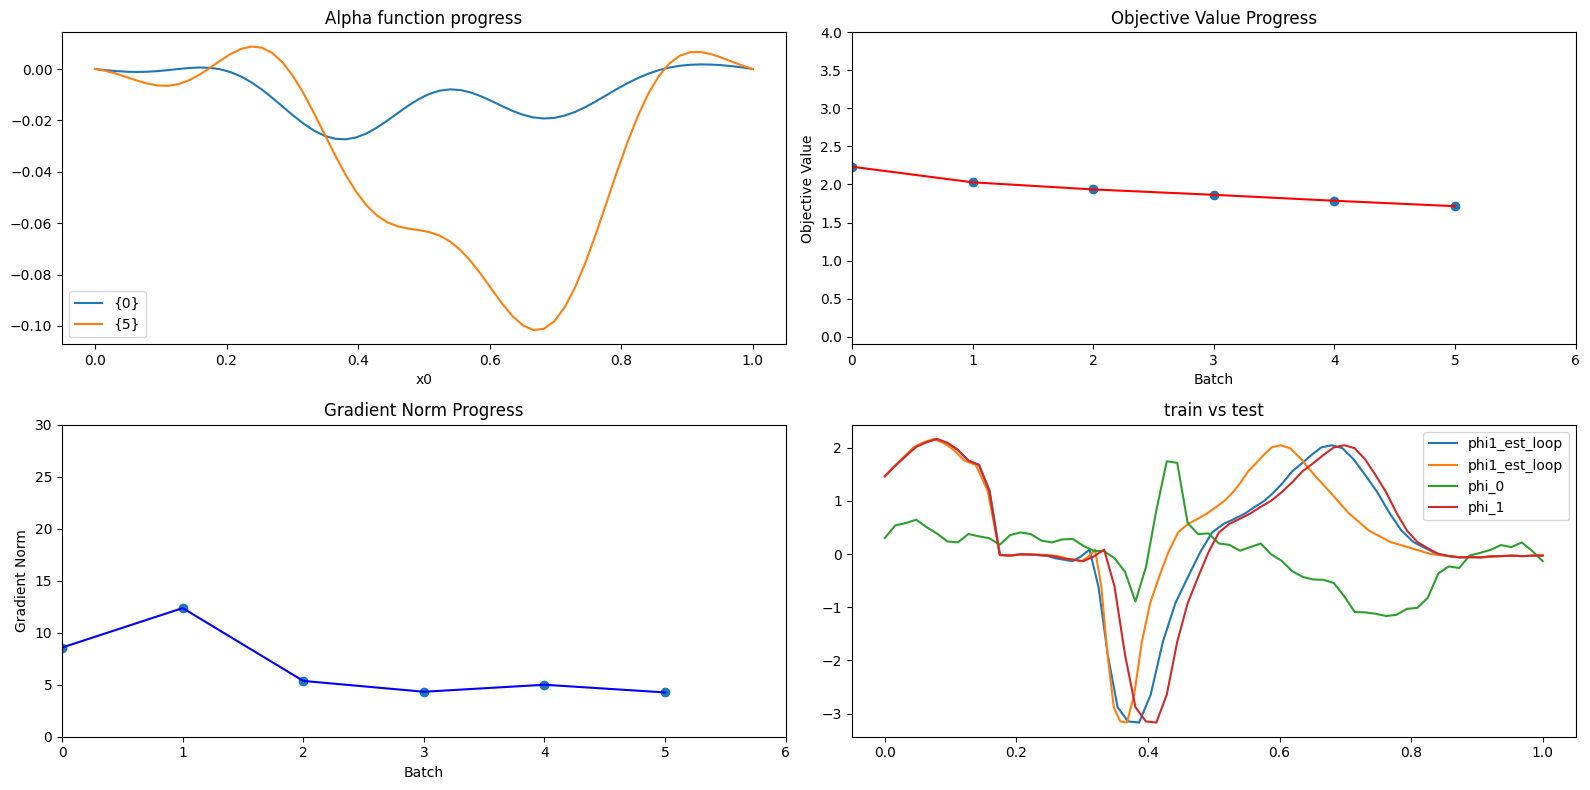

In [ ]:
iter = 6 #
BETA = tf.Variable(b_ini)
#BETA = beta_true
#lr = 1e-3
# lr = 1e-2
#lr = .0115
lr = 1/(2**8)
print(f'learning rate {lr}')
LAMBDA = 1e-5

#label phi1 and phi0
phione = N_train_sub[:,4:5]
phinot = L_test_sub[:,0:1]

fig, ((fig1, fig2), (fig3, fig4)) = plt.subplots(2, 2, figsize=(16, 8))


# Set x-axis limits to keep it the same throughout the loop
fig2.set_xlim(0, iter)
fig2.set_ylim(-0.1, 4.)
fig3.set_xlim(0, iter)
fig3.set_ylim(0.0, 30.0)  # Adjust this range based on your expected gradient norm values



# Scatter plot points initialization for fig2 and fig3
scatter_obj = fig2.scatter([], [])
line_obj, = fig2.plot([], [], 'r-')

scatter_grad = fig3.scatter([], [])
line_grad, = fig3.plot([], [], 'b-')

# Initialize lists to store objective values
obj_values = []
iterations = []
gradient_norms = []

start_time = time.time()

for batch in range(iter):

  #BETA = tf.Variable(BETA)
  with tf.GradientTape() as tape:
    tape.watch(BETA)
    obj = J_obj(BETA, x = sx0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

  grad = tape.gradient(obj, BETA)

  BETA = BETA - lr * grad
  obj_new = J_obj(BETA, x = sx0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new}')

  if batch % 5 == 0:
    fig1.plot(sx0, tf.transpose(alpha(1, sx0, b = BETA)), label =  {batch})
    x_traj = s_alpha_tf(sx0, b = BETA)
    fig4.plot(x_traj[:,-1],  phinot, label = 'phi1_est_loop')

  # Compute the norm of the gradient and store it for plotting
  grad_norm = np.linalg.norm(grad)
  gradient_norms.append(grad_norm)
  print(f'batch: {batch}, grad norm: {grad_norm}')

  # objective function before beta change
  #obj_old = J(xt1,  BETA,  LAMBDA, phi0fixed = phinot, phi1fixed = phione) #N_train_matrix[:,0:1])
  '''
  J(x_t1, b, LAM = .00001, phi0fixed = N_test_matrix[:,0:1], phi1fixed = N_train_matrix[:,0:1])
  '''

  #print(f'batch: {batch}, old objective: {obj_old}')


  # Store the values for plotting
  obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze
  iterations.append(batch)

  # Update scatter and line plot for the objective values
  scatter_obj.set_offsets(np.c_[iterations, obj_values])
  line_obj.set_data(iterations, obj_values)
  #fig2.annotate( {batch}, (iterations[-1], obj_values[-1]))

  # Update scatter and line plot for the gradient norms in fig3
  scatter_grad.set_offsets(np.c_[iterations, gradient_norms])
  line_grad.set_data(iterations, gradient_norms)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec")

fig1.set_title('Alpha function progress')
fig1.set_xlabel('x0')
fig1.legend();

fig2.set_title('Objective Value Progress')
fig2.set_xlabel('Batch')
fig2.set_ylabel('Objective Value')

fig3.set_title('Gradient Norm Progress')
fig3.set_xlabel('Batch')
fig3.set_ylabel('Gradient Norm')

fig4.set_title('train vs test')
#fig4.plot(np.reshape(x_traj[:,-1], (len(x0),1)),  N_train_matrix[:,0:1], label = 'phi1_est_loop')
fig4.plot(sx0, phione, label = 'phi_0');
fig4.plot(sx0, phinot, label = 'phi_1');
fig4.legend();

plt.tight_layout()
plt.show()

### Loop: L with N using keras sgd

In [ ]:
print(1e-3)
print(1/(2**8))

0.001
0.00390625


learning rate 0.00390625
batch: 0, new objective: [[2.16207334]]
 Batch 0, Loss: [[2.16207334]]
batch: 0, grad norm: 11.056440266132746
batch: 1, new objective: [[2.03668636]]
 Batch 1, Loss: [[2.03668636]]
batch: 1, grad norm: 6.499852633301776
batch: 2, new objective: [[1.94149426]]
 Batch 2, Loss: [[1.94149426]]
batch: 2, grad norm: 5.072528194533097
batch: 3, new objective: [[1.8504388]]
 Batch 3, Loss: [[1.8504388]]
batch: 3, grad norm: 4.913685305487435
batch: 4, new objective: [[1.76469592]]
 Batch 4, Loss: [[1.76469592]]
batch: 4, grad norm: 4.679979806532035
batch: 5, new objective: [[1.68108358]]
 Batch 5, Loss: [[1.68108358]]
batch: 5, grad norm: 4.654836175106912
Elapsed time: 2.1401329040527344 sec


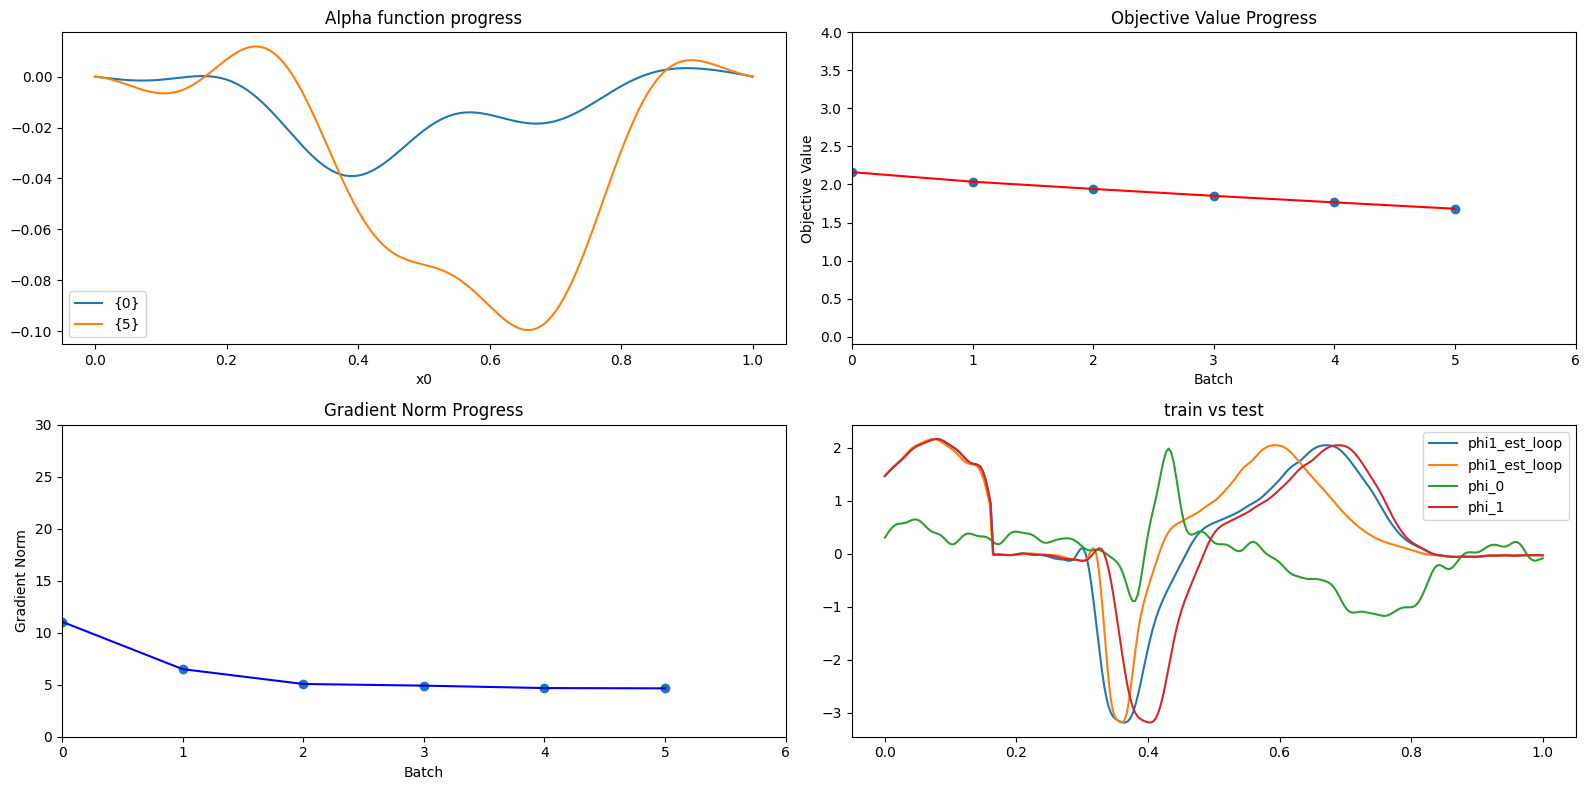

In [ ]:
iter = 6 #
BETA = tf.Variable(b_ini)
lr = 1/(2**8)
print(f'learning rate {lr}')
LAMBDA = 1e-5

optimizer = tf.keras.optimizers.SGD(lr)

#label phi1 and phi0
phione = N_train_matrix[:,4:5]
phinot = L_test_matrix[:,0:1]

fig, ((fig1, fig2), (fig3, fig4)) = plt.subplots(2, 2, figsize=(16, 8))


# Set x-axis limits to keep it the same throughout the loop
fig2.set_xlim(0, iter)
fig2.set_ylim(-0.1, 4.)
fig3.set_xlim(0, iter)
fig3.set_ylim(0.0, 30.0)  # Adjust this range based on your expected gradient norm values



# Scatter plot points initialization for fig2 and fig3
scatter_obj = fig2.scatter([], [])
line_obj, = fig2.plot([], [], 'r-')

scatter_grad = fig3.scatter([], [])
line_grad, = fig3.plot([], [], 'b-')

# Initialize lists to store objective values
obj_values = []
iterations = []
gradient_norms = []

start_time = time.time()

for batch in range(iter):


  with tf.GradientTape() as tape:
    obj = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

  grad = tape.gradient(obj, BETA)
  optimizer.apply_gradients([(grad, BETA)])

  obj_new = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new}')
  if batch % 1 ==0 :
    print(f" Batch {batch}, Loss: {obj_new}")

  #
  if batch % 5 == 0:
    fig1.plot(x0, tf.transpose(alpha(1, x0, b = BETA)), label =  {batch})
    x_traj = s_alpha_tf(x0, b = BETA)
    fig4.plot(x_traj[:,-1],  phinot, label = 'phi1_est_loop')

  # Compute the norm of the gradient and store it for plotting
  grad_norm = np.linalg.norm(grad)
  gradient_norms.append(grad_norm)
  print(f'batch: {batch}, grad norm: {grad_norm}')


  # Store the values for plotting
  obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze
  iterations.append(batch)

  # Update scatter and line plot for the objective values
  scatter_obj.set_offsets(np.c_[iterations, obj_values])
  line_obj.set_data(iterations, obj_values)
  #fig2.annotate( {batch}, (iterations[-1], obj_values[-1]))

  # Update scatter and line plot for the gradient norms in fig3
  scatter_grad.set_offsets(np.c_[iterations, gradient_norms])
  line_grad.set_data(iterations, gradient_norms)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec")

fig1.set_title('Alpha function progress')
fig1.set_xlabel('x0')
fig1.legend();

fig2.set_title('Objective Value Progress')
fig2.set_xlabel('Batch')
fig2.set_ylabel('Objective Value')

fig3.set_title('Gradient Norm Progress')
fig3.set_xlabel('Batch')
fig3.set_ylabel('Gradient Norm')

fig4.set_title('train vs test')
#fig4.plot(np.reshape(x_traj[:,-1], (len(x0),1)),  N_train_matrix[:,0:1], label = 'phi1_est_loop')
fig4.plot(x0, phione, label = 'phi_0');
fig4.plot(x0, phinot, label = 'phi_1');
fig4.legend();

plt.tight_layout()
plt.show()

# Create Distance Matrix for R_train


In [ ]:
print(1e-3)
print(1e-4)
print(1/(2**11))


0.001
0.0001
0.00048828125


## R with R Gradient Descent using opimizer

learning rate 0.00048828125
batch: 0, new objective: [[0.07724561]]
batch: 1, new objective: [[0.0661316]]
batch: 2, new objective: [[0.05946093]]
batch: 3, new objective: [[0.05677793]]
batch: 4, new objective: [[0.05410762]]
batch: 5, new objective: [[0.05340596]]
Elapsed time: 2.1929633617401123 sec


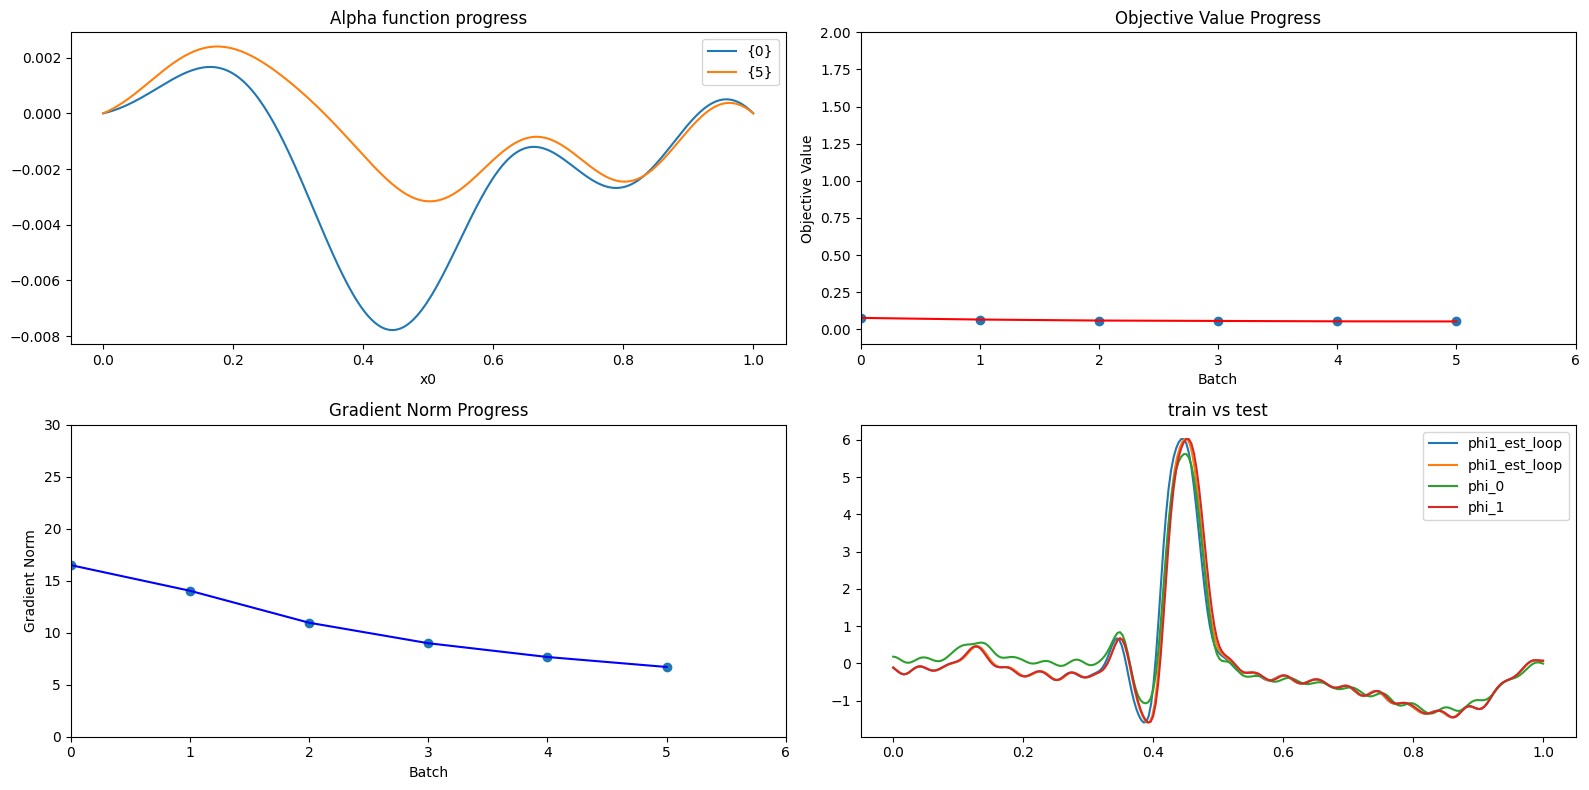

In [ ]:
#test, checking lr
iter = 6 #
BETA = tf.Variable(b_ini)

lr = 1/(2**11)
print(f'learning rate {lr}')
LAMBDA = 1e-4


optimizer = tf.keras.optimizers.SGD(lr)
#label phi1 and phi0
phione = R_train_matrix[:,4:5]
phinot = R_test_matrix[:,0:1]


fig, ((fig1, fig2), (fig3, fig4)) = plt.subplots(2, 2, figsize=(16, 8))


# Set x-axis limits to keep it the same throughout the loop
fig2.set_xlim(0, iter)
fig2.set_ylim(-0.1, 2.)
fig3.set_xlim(0, iter)
fig3.set_ylim(0.0, 30.0)  # Adjust this range based on your expected gradient norm values



# Scatter plot points initialization for fig2 and fig3
scatter_obj = fig2.scatter([], [])
line_obj, = fig2.plot([], [], 'r-')

scatter_grad = fig3.scatter([], [])
line_grad, = fig3.plot([], [], 'b-')


# Initialize lists to store objective values
obj_values = []
iterations = []
gradient_norms = []
sq_dist_values = []
beta_change_values =[]

start_time = time.time()

for batch in range(iter):

  with tf.GradientTape() as tape:
    obj = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

  grad = tape.gradient(obj, BETA)
  optimizer.apply_gradients([(grad, BETA)])

  obj_new = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new}')
  obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze



  if batch % 5 == 0:
    fig1.plot(x0, tf.transpose(alpha(1, x0, b = BETA)), label =  {batch})
    x_traj = s_alpha_tf(x0, BETA)
    fig4.plot(x_traj[:,-1],  phinot, label = 'phi1_est_loop')

  # store sq_Dist
  sq_dist = J1_obj(x0, BETA, phi0fixed = phinot, phi1fixed = phione) #N_train_matrix[:,0:1])
  sq_dist_values.append(np.squeeze(sq_dist))
  #print(f' batch: {batch}, squared_distance: {sq_dist}')

  # store beta_change
  beta_change = J2(BETA, LAMBDA)
  beta_change_values.append(np.squeeze(beta_change))
  #print(f' batch: {batch}, beta_change: {beta_change}')

  # Store grad norms
  grad_norm = tf.norm(grad)
  gradient_norms.append(grad_norm)
  #print(f'batch: {batch}, grad norm: {grad_norm}')


  # Store the values for plotting
  iterations.append(batch)

  # Update scatter and line plot for the objective values
  scatter_obj.set_offsets(np.c_[iterations, obj_values])
  line_obj.set_data(iterations, obj_values)
  #fig2.annotate( {batch}, (iterations[-1], obj_values[-1]))

  # Update scatter and line plot for the gradient norms in fig3
  scatter_grad.set_offsets(np.c_[iterations, gradient_norms])
  line_grad.set_data(iterations, gradient_norms)



end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec")


fig1.set_title('Alpha function progress')
fig1.set_xlabel('x0')
fig1.legend();

fig2.set_title('Objective Value Progress')
fig2.set_xlabel('Batch')
fig2.set_ylabel('Objective Value')

fig3.set_title('Gradient Norm Progress')
fig3.set_xlabel('Batch')
fig3.set_ylabel('Gradient Norm')

fig4.set_title('train vs test')
#fig4.plot(np.reshape(x_traj[:,-1], (len(x0),1)),  N_train_matrix[:,0:1], label = 'phi1_est_loop')
fig4.plot(x0, phione, label = 'phi_0');
fig4.plot(x0, phinot, label = 'phi_1');
fig4.legend();

plt.tight_layout()


0.00048828125


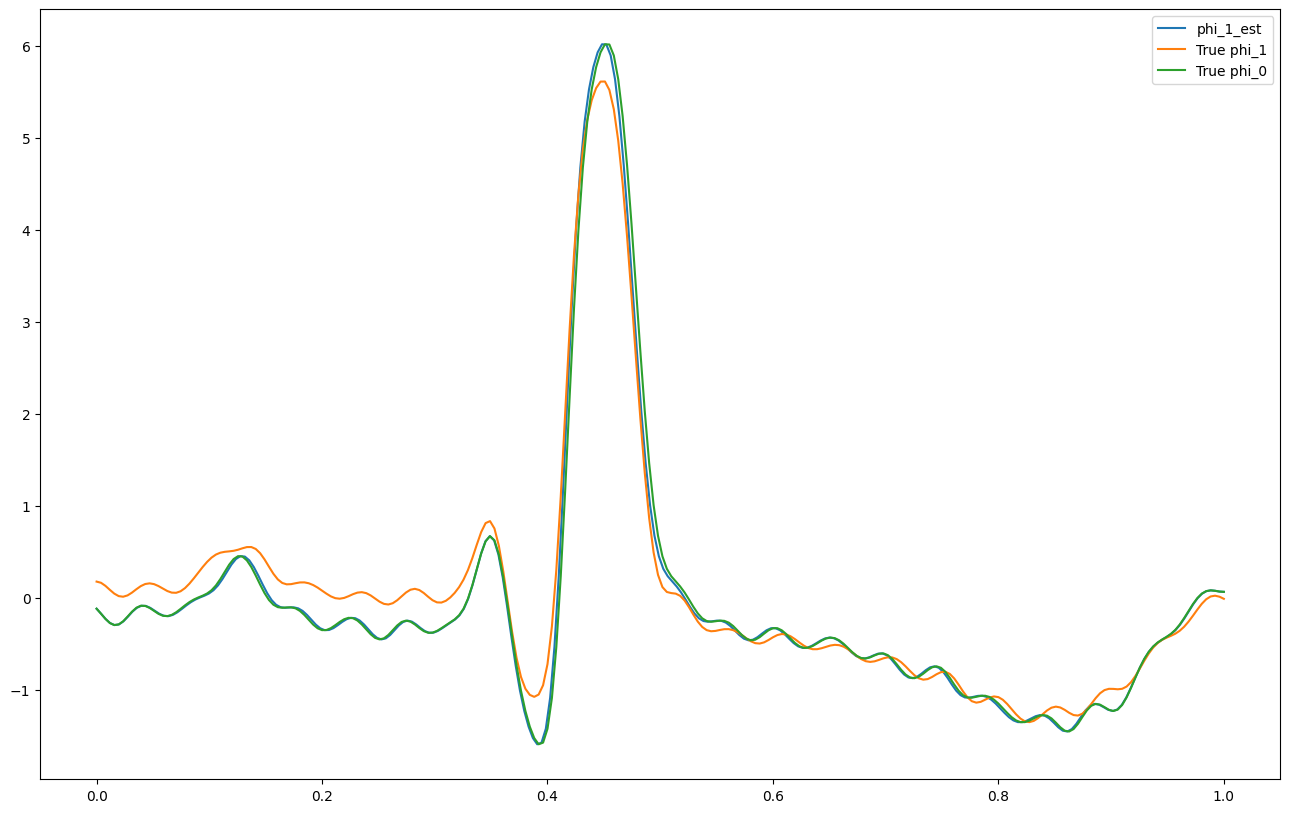

In [ ]:
plt.figure(figsize=(16,10))
x_traj = s_alpha_tf(x0, BETA)
plt.plot(np.reshape(x_traj[:,-1], (len(x0),1)),  phinot, label = 'phi_1_est')
plt.plot(x0, phione, label = 'True phi_1')
plt.plot(x0, phinot, label = 'True phi_0')
print(lr)
plt.legend();

## R with R Subsampling Gradient Descent using opimizer

learning rate 0.00048828125
batch: 0, new objective: [[0.08925673]]
batch: 1, new objective: [[0.06747148]]
batch: 2, new objective: [[0.06101258]]
batch: 3, new objective: [[0.05882856]]
batch: 4, new objective: [[0.05814958]]
batch: 5, new objective: [[0.05789455]]
Elapsed time: 1.5459411144256592 sec


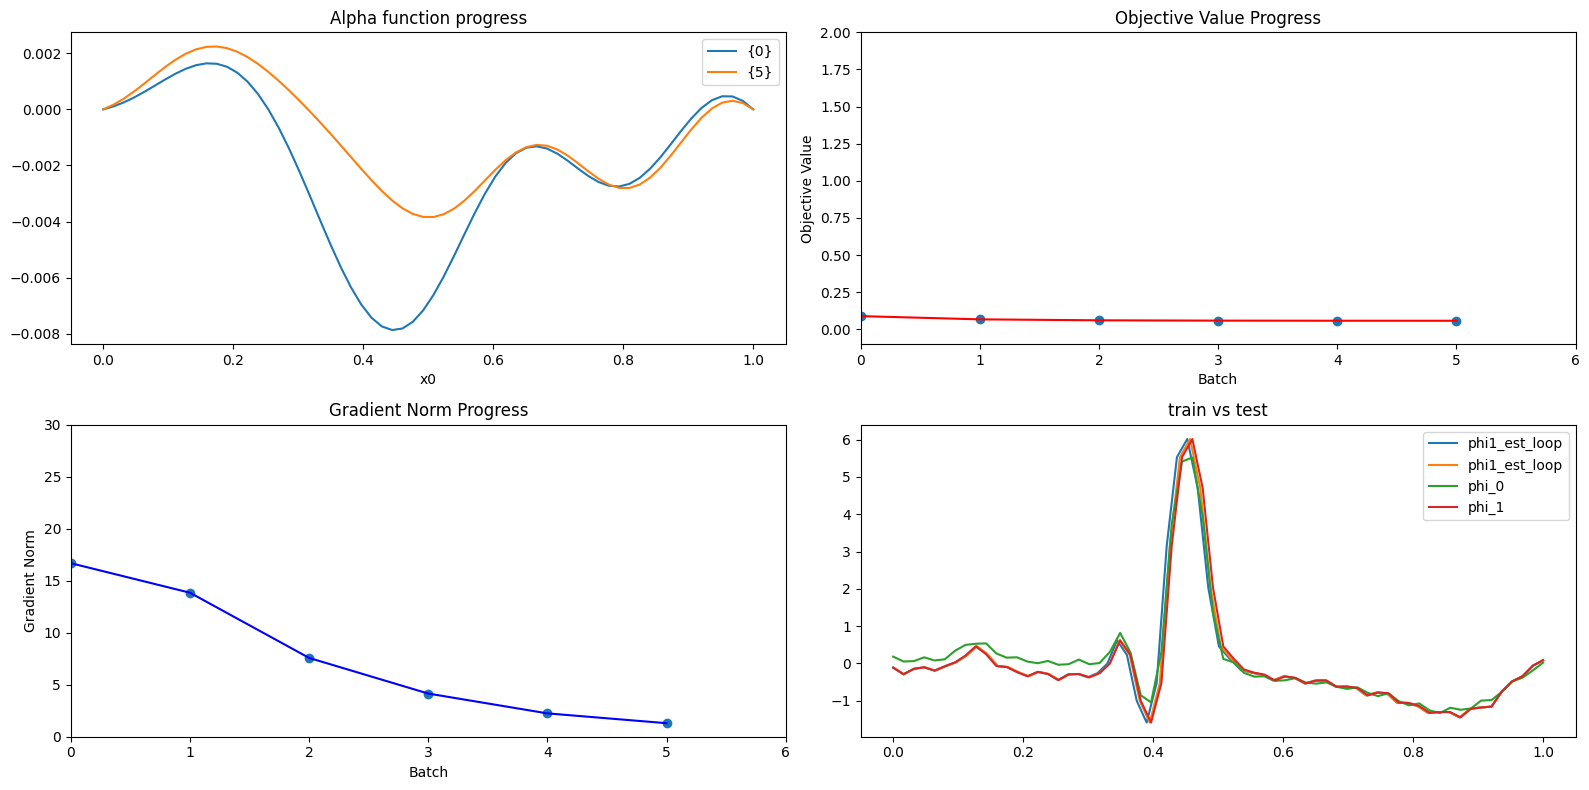

In [ ]:

iter = 6 #
BETA = tf.Variable(b_ini)

lr = 1/(2**11)
print(f'learning rate {lr}')
LAMBDA = 1e-4


optimizer = tf.keras.optimizers.SGD(lr)
#label phi1 and phi0
phione = R_train_sub[:,4:5]
phinot = R_test_sub[:,0:1]


fig, ((fig1, fig2), (fig3, fig4)) = plt.subplots(2, 2, figsize=(16, 8))


# Set x-axis limits to keep it the same throughout the loop
fig2.set_xlim(0, iter)
fig2.set_ylim(-0.1, 2.)
fig3.set_xlim(0, iter)
fig3.set_ylim(0.0, 30.0)  # Adjust this range based on your expected gradient norm values



# Scatter plot points initialization for fig2 and fig3
scatter_obj = fig2.scatter([], [])
line_obj, = fig2.plot([], [], 'r-')

scatter_grad = fig3.scatter([], [])
line_grad, = fig3.plot([], [], 'b-')


# Initialize lists to store objective values
obj_values = []
iterations = []
gradient_norms = []
sq_dist_values = []
beta_change_values =[]

start_time = time.time()

for batch in range(iter):

  with tf.GradientTape() as tape:
    obj = J_obj(BETA, x = sx0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

  grad = tape.gradient(obj, BETA)
  optimizer.apply_gradients([(grad, BETA)])

  obj_new = J_obj(BETA, x = sx0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new}')
  obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze



  if batch % 5 == 0:
    fig1.plot(sx0, tf.transpose(alpha(1, sx0, b = BETA)), label =  {batch})
    x_traj = s_alpha_tf(sx0, BETA)
    fig4.plot(x_traj[:,-1],  phinot, label = 'phi1_est_loop')

  # store sq_Dist
  sq_dist = J1_obj(sx0, BETA, phi0fixed = phinot, phi1fixed = phione) #N_train_matrix[:,0:1])
  sq_dist_values.append(np.squeeze(sq_dist))
  #print(f' batch: {batch}, squared_distance: {sq_dist}')

  # store beta_change
  beta_change = J2(BETA, LAMBDA)
  beta_change_values.append(np.squeeze(beta_change))
  #print(f' batch: {batch}, beta_change: {beta_change}')

  # Store grad norms
  grad_norm = tf.norm(grad)
  gradient_norms.append(grad_norm)
  #print(f'batch: {batch}, grad norm: {grad_norm}')


  # Store the values for plotting
  iterations.append(batch)

  # Update scatter and line plot for the objective values
  scatter_obj.set_offsets(np.c_[iterations, obj_values])
  line_obj.set_data(iterations, obj_values)
  #fig2.annotate( {batch}, (iterations[-1], obj_values[-1]))

  # Update scatter and line plot for the gradient norms in fig3
  scatter_grad.set_offsets(np.c_[iterations, gradient_norms])
  line_grad.set_data(iterations, gradient_norms)



end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec")


fig1.set_title('Alpha function progress')
fig1.set_xlabel('x0')
fig1.legend();

fig2.set_title('Objective Value Progress')
fig2.set_xlabel('Batch')
fig2.set_ylabel('Objective Value')

fig3.set_title('Gradient Norm Progress')
fig3.set_xlabel('Batch')
fig3.set_ylabel('Gradient Norm')

fig4.set_title('train vs test')
#fig4.plot(np.reshape(x_traj[:,-1], (len(x0),1)),  N_train_matrix[:,0:1], label = 'phi1_est_loop')
fig4.plot(sx0, phione, label = 'phi_0');
fig4.plot(sx0, phinot, label = 'phi_1');
fig4.legend();

plt.tight_layout()


## R with R Grad Descent with no document, just obj record

In [ ]:
#test, checking lr
iter = 6 #
BETA = tf.Variable(b_ini)

lr = 1/(2**11)
print(f'learning rate {lr}')
LAMBDA = 1e-4


optimizer = tf.keras.optimizers.SGD(lr)
#label phi1 and phi0
phione = R_train_matrix[:,4:5]
phinot = R_test_matrix[:,0:1]



# Initialize lists to store objective values
obj_values = []
iterations = []
gradient_norms = []
sq_dist_values = []
beta_change_values =[]

start_time = time.time()

for batch in range(iter):

  with tf.GradientTape() as tape:
    obj = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

  grad = tape.gradient(obj, BETA)
  optimizer.apply_gradients([(grad, BETA)])

  obj_new = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new}')
  obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze




  # store sq_Dist
  sq_dist = J1_obj(x0, BETA, phi0fixed = phinot, phi1fixed = phione) #N_train_matrix[:,0:1])
  sq_dist_values.append(np.squeeze(sq_dist))
  #print(f' batch: {batch}, squared_distance: {sq_dist}')

  # store beta_change
  beta_change = J2(BETA, LAMBDA)
  beta_change_values.append(np.squeeze(beta_change))
  #print(f' batch: {batch}, beta_change: {beta_change}')

  # Store grad norms
  grad_norm = tf.norm(grad)
  gradient_norms.append(grad_norm)
  #print(f'batch: {batch}, grad norm: {grad_norm}')


  # Store the values for plotting
  iterations.append(batch)





end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec");

learning rate 0.00048828125
batch: 0, new objective: [[0.07724561]]
batch: 1, new objective: [[0.0661316]]
batch: 2, new objective: [[0.05946093]]
batch: 3, new objective: [[0.05677793]]
batch: 4, new objective: [[0.05410762]]
batch: 5, new objective: [[0.05340596]]
Elapsed time: 2.2972686290740967 sec


## subsampling R with R GD with Keras optimizer

In [ ]:
#test, checking lr
iter = 6 #
BETA = tf.Variable(b_ini)

lr = 1/(2**11)
print(f'learning rate {lr}')
LAMBDA = 1e-4


optimizer = tf.keras.optimizers.SGD(lr)
#label phi1 and phi0
phione = R_train_sub[:,4:5]
phinot = R_test_sub[:,0:1]



# Initialize lists to store objective values
obj_values = []
iterations = []
gradient_norms = []
sq_dist_values = []
beta_change_values =[]

start_time = time.time()

for batch in range(iter):

  with tf.GradientTape() as tape:
    #tape.watch(BETA)
    obj = J_obj(BETA, x = sx0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

  grad = tape.gradient(obj, BETA)
  optimizer.apply_gradients([(grad, BETA)])

  obj_new = J_obj(BETA, x = sx0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new}')
  obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze




  # store sq_Dist
  sq_dist = J1_obj(sx0, BETA, phi0fixed = phinot, phi1fixed = phione) #N_train_matrix[:,0:1])
  sq_dist_values.append(np.squeeze(sq_dist))
  #print(f' batch: {batch}, squared_distance: {sq_dist}')

  # store beta_change
  beta_change = J2(BETA, LAMBDA)
  beta_change_values.append(np.squeeze(beta_change))
  #print(f' batch: {batch}, beta_change: {beta_change}')

  # Store grad norms
  grad_norm = tf.norm(grad)
  gradient_norms.append(grad_norm)
  #print(f'batch: {batch}, grad norm: {grad_norm}')


  # Store the values for plotting
  iterations.append(batch)





end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec");

learning rate 0.00048828125
batch: 0, new objective: [[0.08925673]]
batch: 1, new objective: [[0.06747148]]
batch: 2, new objective: [[0.06101258]]
batch: 3, new objective: [[0.05882856]]
batch: 4, new objective: [[0.05814958]]
batch: 5, new objective: [[0.05789455]]
Elapsed time: 2.0231144428253174 sec


# Let' s do this!

## Distance Matrix

In [ ]:
print(R_train_matrix.shape)
print(R_test_matrix.shape)
phione_m = R_train_matrix
phinot_m = R_test_matrix

print(phione_m.shape)
print(phinot_m.shape)
print(len(phione_m[0]))
print(len(phinot_m[0]))
print(phione_m[:,0].shape)
print(phinot_m[:,0].shape)

(256, 10)
(256, 500)
(256, 10)
(256, 500)
10
500
(256,)
(256,)


## BIG RR Distance Matrix using keras GD

## W/O sampling

In [ ]:
# Don't touch this, this is just a reference for me

#test, checking lr
iter = 6 #
BETA = tf.Variable(b_ini)

lr = 1/(2**11)
print(f'learning rate {lr}')
LAMBDA = 1e-4


optimizer = tf.keras.optimizers.SGD(lr)
#label phi1 and phi0
phione = R_train_matrix[:,4:5]
phinot = R_test_matrix_test_matrix[:,0:1]



# Initialize lists to store objective values
obj_values = []
iterations = []
gradient_norms = []
sq_dist_values = []
beta_change_values =[]

start_time = time.time()

for batch in range(iter):

  with tf.GradientTape() as tape:
    #tape.watch(BETA)
    obj = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

  grad = tape.gradient(obj, BETA)
  optimizer.apply_gradients([(grad, BETA)])

  obj_new = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new}')
  obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze




  # store sq_Dist
  sq_dist = J1_obj(x0, BETA, phi0fixed = phinot, phi1fixed = phione) #N_train_matrix[:,0:1])
  sq_dist_values.append(np.squeeze(sq_dist))
  print(f' batch: {batch}, squared_distance: {sq_dist}')

  # store beta_change
  beta_change = J2(BETA, LAMBDA)
  beta_change_values.append(np.squeeze(beta_change))
  print(f' batch: {batch}, beta_change: {beta_change}')

  # Store grad norms
  grad_norm = tf.norm(grad)
  gradient_norms.append(grad_norm)
  print(f'batch: {batch}, grad norm: {grad_norm}')


  # Store the values for plotting
  iterations.append(batch)





end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec");

learning rate 0.00048828125
batch: 0, new objective: [[0.07724561]]
 batch: 0, squared_distance: [0.07724558]
 batch: 0, beta_change: [[2.4323553e-08]]
batch: 0, grad norm: 16.50445284948988
batch: 1, new objective: [[0.0661316]]
 batch: 1, squared_distance: [0.06613159]
 batch: 1, beta_change: [[1.84334385e-08]]
batch: 1, grad norm: 14.039921740374691
batch: 2, new objective: [[0.05946093]]
 batch: 2, squared_distance: [0.05946091]
 batch: 2, beta_change: [[2.24027769e-08]]
batch: 2, grad norm: 10.965738394277727
batch: 3, new objective: [[0.05677793]]
 batch: 3, squared_distance: [0.05677792]
 batch: 3, beta_change: [[1.89281747e-08]]
batch: 3, grad norm: 8.99445043331919
batch: 4, new objective: [[0.05410762]]
 batch: 4, squared_distance: [0.0541076]
 batch: 4, beta_change: [[2.18294898e-08]]
batch: 4, grad norm: 7.667759333633779
batch: 5, new objective: [[0.05340596]]
 batch: 5, squared_distance: [0.05340594]
 batch: 5, beta_change: [[1.93114798e-08]]
batch: 5, grad norm: 6.708833

In [ ]:
print(1/(2**10))

0.0009765625


learning rate 0.001953125
batch: 0, new objective: [[1.24318799]]
batch: 1, new objective: [[1.05781769]]
batch: 2, new objective: [[0.94996572]]
batch: 3, new objective: [[0.88166679]]
batch: 4, new objective: [[0.83664364]]
batch: 5, new objective: [[0.7957905]]
batch: 6, new objective: [[0.76545077]]
batch: 7, new objective: [[0.74005134]]
batch: 8, new objective: [[0.71716949]]
batch: 9, new objective: [[0.69463615]]
batch: 10, new objective: [[0.67270736]]
Elapsed time: 6.176992654800415 sec


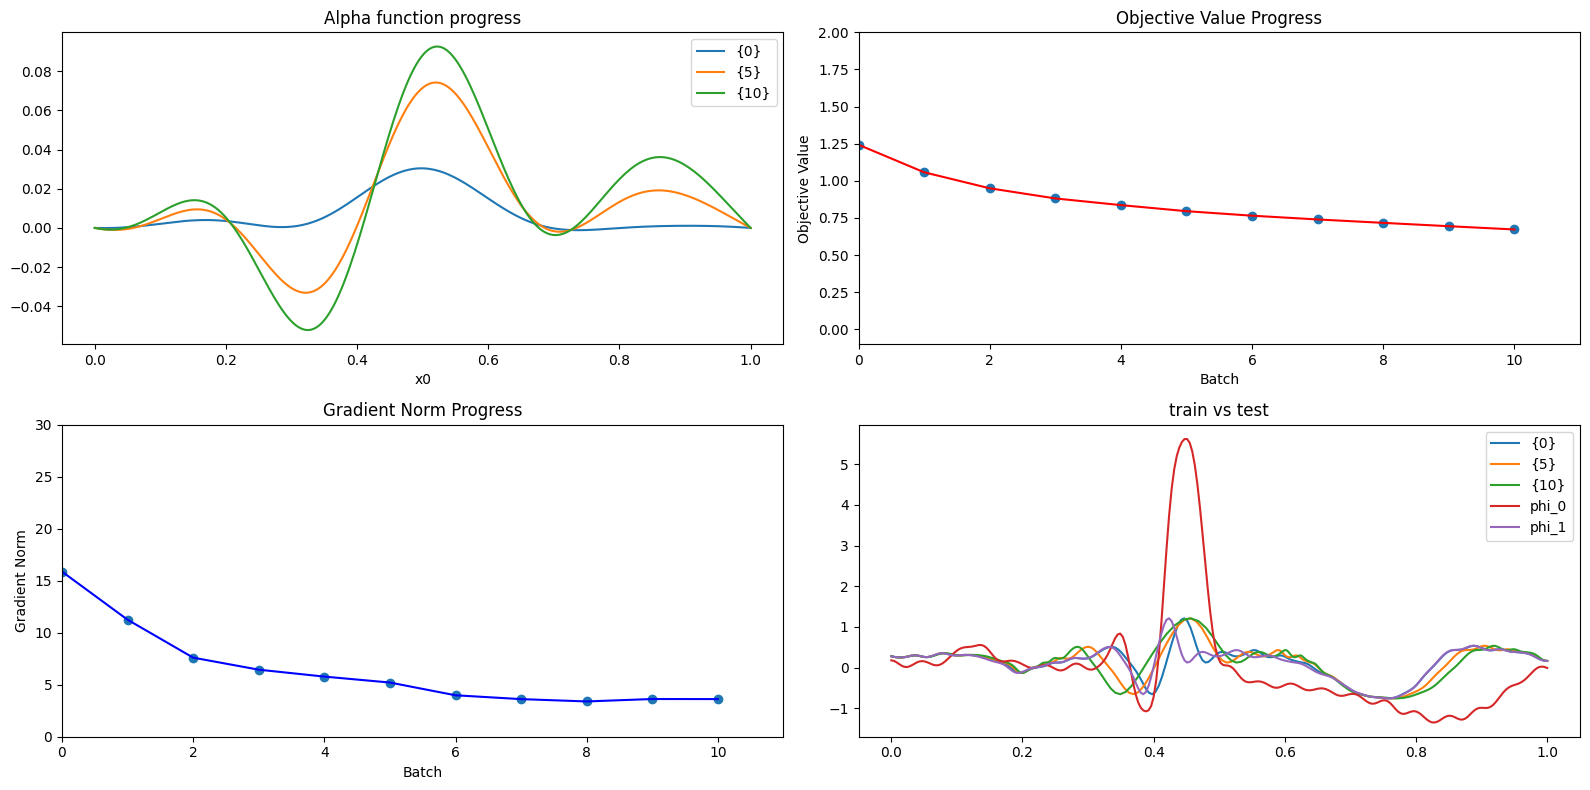

In [ ]:
#test, checking lr
# RN
iter = 11 #
BETA = tf.Variable(b_ini)

lr = 1/(2**9)
print(f'learning rate {lr}')
LAMBDA = 1e-4


optimizer = tf.keras.optimizers.SGD(lr)
#label phi1 and phi0
phione = R_train_matrix[:,4:5]
phinot = N_test_matrix[:,0:1]


fig, ((fig1, fig2), (fig3, fig4)) = plt.subplots(2, 2, figsize=(16, 8))


# Set x-axis limits to keep it the same throughout the loop
fig2.set_xlim(0, iter)
fig2.set_ylim(-0.1, 2.)
fig3.set_xlim(0, iter)
fig3.set_ylim(0.0, 30.0)  # Adjust this range based on your expected gradient norm values



# Scatter plot points initialization for fig2 and fig3
scatter_obj = fig2.scatter([], [])
line_obj, = fig2.plot([], [], 'r-')

scatter_grad = fig3.scatter([], [])
line_grad, = fig3.plot([], [], 'b-')


# Initialize lists to store objective values
obj_values = []
iterations = []
gradient_norms = []
sq_dist_values = []
beta_change_values =[]

start_time = time.time()

for batch in range(iter):

  with tf.GradientTape() as tape:
    obj = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

  grad = tape.gradient(obj, BETA)
  optimizer.apply_gradients([(grad, BETA)])

  obj_new = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
  print(f'batch: {batch}, new objective: {obj_new}')
  obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze



  if batch % 5 == 0:
    fig1.plot(x0, tf.transpose(alpha(1, x0, b = BETA)), label =  {batch})
    x_traj = s_alpha_tf(x0, BETA)
    fig4.plot(x_traj[:,-1],  phinot, label = {batch} )

  # store sq_Dist
  sq_dist = J1_obj(x0, BETA, phi0fixed = phinot, phi1fixed = phione) #N_train_matrix[:,0:1])
  sq_dist_values.append(np.squeeze(sq_dist))
  #print(f' batch: {batch}, squared_distance: {sq_dist}')

  # store beta_change
  beta_change = J2(BETA, LAMBDA)
  beta_change_values.append(np.squeeze(beta_change))
  #print(f' batch: {batch}, beta_change: {beta_change}')

  # Store grad norms
  grad_norm = tf.norm(grad)
  gradient_norms.append(grad_norm)
  #print(f'batch: {batch}, grad norm: {grad_norm}')


  # Store the values for plotting
  iterations.append(batch)

  # Update scatter and line plot for the objective values
  scatter_obj.set_offsets(np.c_[iterations, obj_values])
  line_obj.set_data(iterations, obj_values)
  #fig2.annotate( {batch}, (iterations[-1], obj_values[-1]))

  # Update scatter and line plot for the gradient norms in fig3
  scatter_grad.set_offsets(np.c_[iterations, gradient_norms])
  line_grad.set_data(iterations, gradient_norms)



end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} sec")


fig1.set_title('Alpha function progress')
fig1.set_xlabel('x0')
fig1.legend();

fig2.set_title('Objective Value Progress')
fig2.set_xlabel('Batch')
fig2.set_ylabel('Objective Value')

fig3.set_title('Gradient Norm Progress')
fig3.set_xlabel('Batch')
fig3.set_ylabel('Gradient Norm')

fig4.set_title('train vs test')
#fig4.plot(np.reshape(x_traj[:,-1], (len(x0),1)),  N_train_matrix[:,0:1], label = 'phi1_est_loop')
fig4.plot(x0, phione, label = 'phi_0');
fig4.plot(x0, phinot, label = 'phi_1');
fig4.legend();

plt.tight_layout()


In [ ]:
##################
# RN
##################
iter = 6 #
BETA = tf.Variable(b_ini)

lr = 1/(2**9)
print(f'learning rate: {lr}')
optimizer = tf.keras.optimizers.SGD(lr)

LAMBDA = 1e-4

#label phi1 and phi0
phione_m = R_train_matrix
phinot_m = N_test_matrix

train_datapoints = len(phione_m[0])# 10 for each one
test_datapoints = len(phinot_m[0]) # number of dataq points (1000, 982, 202, 500, 40)


# Initialize lists to store objective values
obj_values = []
iterations = []
gradient_norms = []
sq_dist_values = []
beta_change_values =[]

# Elapsed time for each comparison
e_time = []

# Three different Values for Distance
dist_obj = np.zeros((train_datapoints , test_datapoints))
dist_sd = np.zeros((train_datapoints , test_datapoints))
dist_b = np.zeros((train_datapoints , test_datapoints))
e_t = np.zeros((train_datapoints , test_datapoints))
count = 0
start_time = time.time()
for i in range(train_datapoints):      #10 TRAIN
  for j in range(test_datapoints):     #For R: 500 TEST
    count += 1
    print(f'{count} of {train_datapoints * test_datapoints}')
    phione = phione_m[:,i:i+1]
    #print(phione[0:5,:])
    phinot = phinot_m[:,j:j+1]
    #print(phinot[0:5,:])


    start_time_batch = time.time()
    for batch in range(iter):
      with tf.GradientTape() as tape:
        #tape.watch(BETA)
        obj = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

      grad = tape.gradient(obj, BETA)
      optimizer.apply_gradients([(grad, BETA)])

      obj_new = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
      print(f'batch: {batch}, new objective: {obj_new}')
      obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze




      # store sq_Dist
      sq_dist = J1_obj(x0, BETA, phi0fixed = phinot, phi1fixed = phione) #N_train_matrix[:,0:1])
      sq_dist_values.append(np.squeeze(sq_dist))
      #print(f' batch: {batch}, squared_distance: {sq_dist}')

      # store beta_change
      beta_change = J2(BETA, LAMBDA)
      beta_change_values.append(np.squeeze(beta_change))
      #print(f' batch: {batch}, beta_change: {beta_change}')

      # Store grad norms
      grad_norm = tf.norm(grad)
      gradient_norms.append(grad_norm)
      #print(f'batch: {batch}, grad norm: {grad_norm}')


      # Store the values for plotting
      iterations.append(batch)





    end_time_batch = time.time()
    elapsed_time = end_time_batch - start_time_batch
    print(f"Elapsed time: {elapsed_time} seconds")
    e_time.append(elapsed_time)

    # List of times for each iter
    #print(e_time[-1])
    #print(e_time)
    e_t[i,j] = elapsed_time
    # Dist obj value matrix, put latest obj_new value
    #print(obj_values[-1])
    dist_obj[i,j] = np.squeeze(obj_new) # latest obj_value in tensor, so squeeze
    #print(f' latest Obj Value for {iter}: {dist_obj_RR[i,j]}')

    # Dist squared matrix, put latest sq_dist value
    #print(sq_dist_values[-1])
    dist_sd[i,j] = np.squeeze(sq_dist)
    #print(f' latest squared distance value for {iter}: {dist_obj_RR[i,j]}')

    # Dist beta change matrix
    #print(beta_change_values[-1])
    dist_b[i,j] = np.squeeze(beta_change)
    #print(f' latest \lambda BetaTBeta value for {iter}: {dist_b_RR[i,j]}')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time/(60*60)} hrs");

Streaming output truncated to the last 5000 lines.
batch: 0, new objective: [[0.33782998]]
batch: 1, new objective: [[0.33782914]]
batch: 2, new objective: [[0.33782827]]
batch: 3, new objective: [[0.33782741]]
batch: 4, new objective: [[0.33782655]]
batch: 5, new objective: [[0.33782568]]
Elapsed time: 2.2216620445251465 seconds
9377 of 10000
batch: 0, new objective: [[0.28320337]]
batch: 1, new objective: [[0.28320281]]
batch: 2, new objective: [[0.28320226]]
batch: 3, new objective: [[0.2832017]]
batch: 4, new objective: [[0.28320115]]
batch: 5, new objective: [[0.28320057]]
Elapsed time: 2.060072422027588 seconds
9378 of 10000
batch: 0, new objective: [[0.13788698]]
batch: 1, new objective: [[0.13788686]]
batch: 2, new objective: [[0.13788675]]
batch: 3, new objective: [[0.13788663]]
batch: 4, new objective: [[0.13788652]]
batch: 5, new objective: [[0.13788639]]
Elapsed time: 2.042079210281372 seconds
9379 of 10000
batch: 0, new objective: [[0.24479026]]
batch: 1, new objective: [[

In [ ]:
# RR_train
# prompt: Make dist_matrix into a csv


# Convert the numpy array to a pandas DataFrame
df_RN_dist_obj  = pd.DataFrame(dist_obj)
df_RN_dist_sd  = pd.DataFrame(dist_sd)
df_RN_dist_b  = pd.DataFrame(dist_b)
df_RN_e_t = pd.DataFrame(e_t)

# Save the DataFrame to a CSV file
df_RN_dist_obj.to_csv('RN_dist_obj.csv', index=False)
df_RN_dist_sd.to_csv('RN_dist_sd.csv', index=False)
df_RN_dist_b.to_csv('RN_dist_b.csv', index=False)
df_RN_e_t.to_csv('RN_e_t.csv', index=False)

#Try to optimize:

In [ ]:
phione_m = R_train_matrix
phinot_m = R_test_matrix
train_datapoints = len(phione_m[0])# 10 for each one
test_datapoints = len(phinot_m[0])

In [ ]:
# Prepare data for mapping
phione_expanded = tf.expand_dims(phione_m, axis=2)  # Shape: (features, train_datapoints, 1)
phinot_expanded = tf.expand_dims(phinot_m, axis=1)  # Shape: (features, 1, test_datapoints)

# Tile to create pairwise combinations
phione_broadcast = tf.tile(phione_expanded, [1, 1, test_datapoints])  # (features, train_datapoints, test_datapoints)
phinot_broadcast = tf.tile(phinot_expanded, [1, train_datapoints, 1])  # (features, train_datapoints, test_datapoints)

#  Step 3: Prepare for mapping
# Reshape to pair each (phione, phinot) column vector
phione_flattened = tf.reshape(phione_broadcast, [-1, tf.shape(phione_m)[0]])  # Shape: (10*500, 256)
phinot_flattened = tf.reshape(phinot_broadcast, [-1, tf.shape(phinot_m)[0]])  # Shape: (10*500, 256)



In [ ]:
print(phione_flattened.shape)
print(phinot_flattened.shape)

In [ ]:

def compute_pairwise_gradient(phione, phinot, b = b_ini, lr = 1/(2**11), LAMBDA = 1e-4, iter = 6):
    """
    Compute gradient and updates for a single (i, j) pair.
    Args:
    - args: A tuple (phione, phinot) containing column vectors from phione_m and phinot_m.
    Returns:
    - A dictionary with computed values for the pair.
    """


    phione = tf.reshape(phione, [256, 1])  # Shape: (features, 1)
    #print(phione[0:5,:])
    phinot = tf.reshape(phinot, [256, 1])
    #print(phinot[0:5,:])



    # Initialize variables for batch iterations


    #BETA = tf.Variable(b)
    optimizer = tf.keras.optimizers.SGD(lr)

    # Track time
    start_time_batch = tf.timestamp()

    #obj_new = None

    start_time_batch = time.time()
    for batch in range(iter):
      with tf.GradientTape() as tape:
        #tape.watch(BETA)
        obj = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
        print(BETA[0:5,:])
      grad = tape.gradient(obj, BETA)
      optimizer.apply_gradients([(grad, BETA)])

      obj_new = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
      print(f'batch: {batch}, new objective: {obj_new}')
      obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze

    obj_new = J_obj(BETA, x = x0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
    #print(f'batch: {batch}, new objective: {obj_new}')
    obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze


    # Elapsed time
    end_time_batch = tf.timestamp()
    elapsed_time = end_time_batch - start_time_batch
    print(f"Elapsed time: {elapsed_time} seconds")

    return {
        "objective": obj_new,
        "elapsed_time": elapsed_time,
    }


In [ ]:
print(phione_batch.shape)
print(phinot_batch.shape)
print(phinot_batch[0].shape)
print(phione_batch[0].shape)
print(phinot_batch_reshaped.shape)

In [ ]:
# Use tf.map_fn to compute for all pairs
BETA = tf.Variable(b_ini)
results = tf.map_fn(
    fn=lambda x: compute_pairwise_gradient(x[0], x[1]),
    elems=(phione_flattened, phinot_flattened),
    fn_output_signature={
        "objective": tf.float64,
        "elapsed_time": tf.float64
    }
)

# Extract results
dist_obj_RR = results["objective"]  # Objectives for all pairs
e_t = results["elapsed_time"]       # Elapsed times for all pairs


In [ ]:
e_t

## RR Distance with subsampling filtered data


In [ ]:
##################
# RR subsampling
##################
iter = 6 #
BETA = tf.Variable(b_ini)

lr = 1/(2**11)
print(f'learning rate: {lr}')
optimizer = tf.keras.optimizers.SGD(lr)

LAMBDA = 1e-4

#label phi1 and phi0
phione_m = R_train_sub
phinot_m = R_test_sub

train_datapoints = len(phione_m[0])# 10 for each one
test_datapoints = len(phinot_m[0]) # number of dataq points (1000, 982, 202, 500, 40)


# Initialize lists to store objective values
obj_values = []
iterations = []
gradient_norms = []
sq_dist_values = []
beta_change_values =[]

# Elapsed time for each comparison
e_time = []

# Three different Values for Distance
dist_obj_RR = np.zeros((train_datapoints , test_datapoints))
dist_sd_RR = np.zeros((train_datapoints , test_datapoints))
dist_b_RR = np.zeros((train_datapoints , test_datapoints))
e_t = np.zeros((train_datapoints , test_datapoints))
count = 0
start_time = time.time()
for i in range(train_datapoints):      #10 TRAIN
  for j in range(test_datapoints):     #For R: 500 TEST
    count += 1
    print(f'{count} of {train_datapoints * test_datapoints}')
    phione = phione_m[:,i:i+1]
    phinot = phinot_m[:,j:j+1]


    start_time_batch = time.time()
    for batch in range(iter):
      with tf.GradientTape() as tape:
        #tape.watch(BETA)
        obj = J_obj(BETA, x = sx0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)

      grad = tape.gradient(obj, BETA)
      optimizer.apply_gradients([(grad, BETA)])

      obj_new = J_obj(BETA, x = sx0, LAM = LAMBDA, phi0fixed = phinot, phi1fixed = phione)
      print(f'batch: {batch}, new objective: {obj_new}')
      obj_values.append(np.squeeze(obj_new)) #obj is a tensor, remove it by squeeze




      # store sq_Dist
      sq_dist = J1_obj(sx0, BETA, phi0fixed = phinot, phi1fixed = phione) #N_train_matrix[:,0:1])
      sq_dist_values.append(np.squeeze(sq_dist))
      #print(f' batch: {batch}, squared_distance: {sq_dist}')

      # store beta_change
      beta_change = J2(BETA, LAMBDA)
      beta_change_values.append(np.squeeze(beta_change))
      #print(f' batch: {batch}, beta_change: {beta_change}')

      # Store grad norms
      grad_norm = tf.norm(grad)
      gradient_norms.append(grad_norm)
      #print(f'batch: {batch}, grad norm: {grad_norm}')


      # Store the values for plotting
      iterations.append(batch)





    end_time_batch = time.time()
    elapsed_time = end_time_batch - start_time_batch
    print(f"Elapsed time: {elapsed_time} seconds")
    e_time.append(elapsed_time)

    # List of times for each iter
    #print(e_time[-1])
    #print(e_time)
    e_t[i,j] = elapsed_time
    # Dist obj value matrix, put latest obj_new value
    #print(obj_values[-1])
    dist_obj_RR[i,j] = np.squeeze(obj_new) # latest obj_value in tensor, so squeeze
    #print(f' latest Obj Value for {iter}: {dist_obj_RR[i,j]}')

    # Dist squared matrix, put latest sq_dist value
    #print(sq_dist_values[-1])
    dist_sd_RR[i,j] = np.squeeze(sq_dist)
    #print(f' latest squared distance value for {iter}: {dist_obj_RR[i,j]}')

    # Dist beta change matrix
    #print(beta_change_values[-1])
    dist_b_RR[i,j] = np.squeeze(beta_change)
    #print(f' latest \lambda BetaTBeta value for {iter}: {dist_b_RR[i,j]}')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time/(60*60)} hrs");